In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def get_ranks(good_df,ypred):
    cutoff=0.2
    #print (codedata,ypred,ydata)
    #print (len(ypred),len(good_df.mm.to_list()))
    d = {'code':good_df.code.to_list(),'pred':ypred,
         "dockQ":good_df.dockQ.to_list(),"params":good_df.params.to_list(),
        "mm":good_df.mm.to_list()}
    res_df=pd.DataFrame(d).sort_values("pred")
    #res_df.sort_values("CODE")

    i=0
    sumdiff=0
    mmdiff=0
    correct=0
    for code in res_df.code.unique():
        topranked=res_df.loc[res_df.code==code].sort_values("pred")["dockQ"][-1:].max()
        best=res_df.loc[res_df.code==code]["dockQ"].max()
        mmtop=res_df.loc[res_df.code==code].sort_values("pred")["mm"][-1:].max()
        mmbest=res_df.loc[res_df.code==code]["mm"].max()
        #print (code,topranked,best)
        if best>cutoff:
            i+=1
            sumdiff+=best-topranked
            mmdiff+=mmbest-mmtop
            if topranked>cutoff:
                correct+=1
    #print (i,correct,round(sumdiff/i,3))            
    return (i,correct,sumdiff,mmdiff)

In [4]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()

In [5]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",")
df=df.dropna()

In [6]:
sns.set(style="whitegrid")

In [7]:
df["name"]
df.keys()

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'dockQ',
       'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long', 'med',
       'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA', 'longB',
       'medB', 'longPPVB', 'medPPVB', 'auc', 'evalue', 'seqid', 'rank'],
      dtype='object')

In [8]:

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]

In [9]:
r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
notRosettaset=list(filter(r.match, datasets))
df2=df.loc[~df.JHparams.isin(notRosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"
df2

name   JHparams  lenA  lenB     msa    msaA   msaB  \
0      1ay7_u1_A-1ay7_u2_A  trRosetta    97    90  1060.0    1485   2034   
1      1ay7_u2_A-1ay7_u1_A  trRosetta    90    97  1060.0    2034   1485   
2      1b27_u1_A-1b27_u2_A  trRosetta   109    90   733.0    1484   2034   
3      1b27_u2_A-1b27_u1_A  trRosetta    90   109   733.0    2034   1484   
4      1bdj_u1_A-1bdj_u2_A  trRosetta   129   118  5651.0  349880  23051   
...                    ...        ...   ...   ...     ...     ...    ...   
10241  4y5o_u1_A-4y5o_u2_A  trRosetta    94    85    34.0      0.     0.   
10242  4zfr_u1_A-4zfr_u2_A  trRosetta   186    77    12.0      0.     0.   
10243  5brr_u1_A-5brr_u2_A  trRosetta   378   266   107.0      0.     0.   
10244  5cec_u1_A-5cec_u2_A  trRosetta   403   191     7.0      0.     0.   
10245  5eg3_u1_A-5eg3_u2_A  trRosetta   303   105     7.0      0.     0.   

       dockQ   fnat     iRMS  ...  medB  longPPVB  medPPVB   auc  evalue  \
0      0.298  0.222    3.561  ...   116     0.985    0.966  0.40  9999.0   
1      0.254  0.278    4.395  ...   150     0.960    0.987  0.36  9999.0   
2      0.223  0.120    4.508  ...   113     0.992    0.965  0.46     4.3   
3      0.231  0.160    4.840  ...   154     0.971    0.981  0.46     4.3   
4      0.000  0.000  211.527  ...    92     0.996    1.000  0.00  9999.0   
...      ...    ...      ...  ...   ...       ...      ...   ...     ...   
10241  0.055  0.000   11.394  ...    41     0.972    0.951  0.00  9999.0   
10242  0.048  0.000   14.464  ...    37     0.846    0.946  0.09  9999.0   
10243  0.009  0.000   18.458  ...   306     0.995    1.000  0.00   236.0   
10244  0.011  0.000   20.074  ...   109     0.737    0.367  0.00   197.0   
10245  0.003  0.000   39.956  ...    29     0.858    0.862  0.00    68.0   

        seqid  rank  code  CODE     params  
0       0.000     1  1ay7  1ay7  trRosetta  
1       0.000     2  1ay7  1ay7  trRosetta  
2      50.000     1  1b27  1b27  trRosetta  
3      50.000     2  1b27  1b27  trRosetta  
4       0.000     1  1bdj  1bdj  trRosetta  
...       ...   ...   ...   ...        ...  
10241   0.000     1  4y5o  4y5o  trRosetta  
10242   0.000     1  4zfr  4zfr  trRosetta  
10243  66.667     1  5brr  5brr  trRosetta  
10244  33.333     1  5cec  5cec  trRosetta  
10245  40.000     1  5eg3  5eg3  trRosetta  

[4026 rows x 34 columns]

In [10]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.JHparams.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [11]:
r=re.compile("^PDB|^pdb")
datasets=df.JHparams.unique()
pdbset=list(filter(r.match, datasets))
df2=df.loc[(df.JHparams.isin(pdbset))&(~df.JHparams.isin(["pdbconfold"]))].copy()
df2.JHparams="PDB"
df2.params="PDB"
df2

name JHparams  lenA  lenB     msa msaA msaB  dockQ  \
6567  1bdj_u1_A-1bdj_u2_A      PDB   129   118  5651.0   0.   0.  0.827   
6568  1bdj_u2_A-1bdj_u1_A      PDB   118   129  5651.0   0.   0.  0.140   
6569  1ewy_u1_A-1ewy_u2_A      PDB   304    99  4396.0   0.   0.  0.608   
6570  1ewy_u2_A-1ewy_u1_A      PDB    99   304  4396.0   0.   0.  0.681   
6571  1jtd_u1_A-1jtd_u2_A      PDB   270   264   176.0   0.   0.  0.522   
...                   ...      ...   ...   ...     ...  ...  ...    ...   
9642  4gmj_u1_A-4gmj_u2_A      PDB   253   236  1189.0   0.   0.  0.051   
9643  4llo_u1_A-4llo_u2_A      PDB   147   115  6332.0   0.   0.  0.081   
9644  4llo_u2_A-4llo_u1_A      PDB   115   147  6332.0   0.   0.  0.099   
9645  5brr_u1_A-5brr_u2_A      PDB   378   266   611.0   0.   0.  0.002   
9646  5brr_u2_A-5brr_u1_A      PDB   266   378   593.0   0.   0.  0.031   

       fnat    iRMS  ...  medB  longPPVB  medPPVB   auc  evalue   seqid  rank  \
6567  0.765   0.902  ...     0       0.0      0.0  0.01  9999.0   0.000     1   
6568  0.353  11.440  ...     0       0.0      0.0  0.07  9999.0   0.000     2   
6569  0.562   2.140  ...     0       0.0      0.0  0.09    20.0  75.000     1   
6570  0.750   2.133  ...     0       0.0      0.0  0.04    20.0  75.000     2   
6571  0.397   2.496  ...     0       0.0      0.0  0.04   132.0  66.667     1   
...     ...     ...  ...   ...       ...      ...   ...     ...     ...   ...   
9642  0.122  11.126  ...     0       0.0      0.0  0.00   114.0  50.000     1   
9643  0.040  10.485  ...     0       0.0      0.0  0.10    41.0  66.667     1   
9644  0.200  10.138  ...     0       0.0      0.0  0.01    41.0  66.667     2   
9645  0.000  19.466  ...     0       0.0      0.0  0.05   236.0  66.667     1   
9646  0.055   8.444  ...     0       0.0      0.0  0.02   222.0  66.667     2   

      code  CODE  params  
6567  1bdj  1bdj     PDB  
6568  1bdj  1bdj     PDB  
6569  1ewy  1ewy     PDB  
6570  1ewy  1ewy     PDB  
6571  1jtd  1jtd     PDB  
...    ...   ...     ...  
9642  4gmj  4gmj     PDB  
9643  4llo  4llo     PDB  
9644  4llo  4llo     PDB  
9645  5brr  5brr     PDB  
9646  5brr  5brr     PDB  

[3080 rows x 34 columns]

In [12]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [13]:
# Add a linear combination of trRosetta
r=re.compile(".*-N.*") # .*cpu.*
datasets=df.JHparams.unique()
JHsets=list(filter(r.match, datasets))



In [14]:
cutoff=0.1
goodmodels=df.loc[(df.dockQ>cutoff)&(df.JHparams.isin(JHsets))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.JHparams.isin(JHsets))] #.reset_index()
good_df

name      JHparams  lenA  lenB     msa    msaA    msaB  \
0     1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8    97    90  1060.0    1485    2034   
1     1ay7_u2_A-1ay7_u1_A  -N 3 --cpu 8    90    97  1060.0    2034    1485   
2     1b27_u1_A-1b27_u2_A  -N 3 --cpu 8   109    90   733.0    1484    2034   
3     1b27_u2_A-1b27_u1_A  -N 3 --cpu 8    90   109   733.0    2034    1484   
30    1gcq_u1_A-1gcq_u2_A  -N 3 --cpu 8    66    57  1365.0   77497   77704   
...                   ...           ...   ...   ...     ...     ...     ...   
5572  4txo_u2_A-4txo_u1_A  -N 5 --cpu 8   158   178  7106.0  115265  131653   
5587  4xs0_u1_A-4xs0_u2_A  -N 5 --cpu 8   147   141  3395.0    9453    9375   
5588  4xs0_u2_A-4xs0_u1_A  -N 5 --cpu 8   141   147  3395.0    9375    9453   
5603  5cra_u1_A-5cra_u2_A  -N 5 --cpu 8   193    77     1.0      11   42026   
5604  5cra_u2_A-5cra_u1_A  -N 5 --cpu 8    77   193     1.0   42026      11   

      dockQ   fnat    iRMS  ...  medB  longPPVB  medPPVB   auc        evalue  \
0     0.298  0.222   3.561  ...   116     0.985    0.966  0.40  9.999000e+03   
1     0.254  0.278   4.395  ...   150     0.960    0.987  0.36  9.999000e+03   
2     0.223  0.120   4.508  ...   113     0.992    0.965  0.46  4.300000e+00   
3     0.231  0.160   4.840  ...   154     0.971    0.981  0.46  4.300000e+00   
30    0.115  0.240  11.587  ...   105     0.995    0.990  0.05  6.320000e-05   
...     ...    ...     ...  ...   ...       ...      ...   ...           ...   
5572  0.014  0.000  18.770  ...   284     0.947    0.930  0.00  7.300000e-02   
5587  0.094  0.222  16.384  ...   125     0.984    0.992  0.03  1.630000e-38   
5588  0.076  0.167  16.224  ...   137     0.996    0.993  0.03  1.630000e-38   
5603  0.008  0.000  21.733  ...    20     0.646    0.300  0.00  9.999000e+03   
5604  0.103  0.000  10.657  ...    16     0.811    0.938  0.17  9.999000e+03   

       seqid  rank  code  CODE        params  
0      0.000     1  1ay7  1ay7  -N 3 --cpu 8  
1      0.000     2  1ay7  1ay7  -N 3 --cpu 8  
2     50.000     1  1b27  1b27  -N 3 --cpu 8  
3     50.000     2  1b27  1b27  -N 3 --cpu 8  
30    31.707     1  1gcq  1gcq  -N 3 --cpu 8  
...      ...   ...   ...   ...           ...  
5572  26.984     2  4txo  4txo  -N 5 --cpu 8  
5587  43.448     1  4xs0  4xs0  -N 5 --cpu 8  
5588  43.448     2  4xs0  4xs0  -N 5 --cpu 8  
5603   0.000     1  5cra  5cra  -N 5 --cpu 8  
5604   0.000     2  5cra  5cra  -N 5 --cpu 8  

[179 rows x 34 columns]

Text(0.5, 1.0, 'CC 0.305 Good: 0.889 Loss: 0.058 , 0.075 Test: 9')

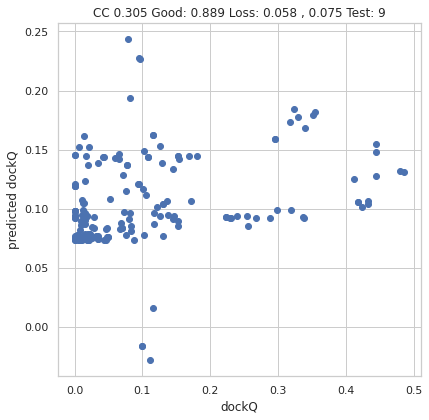

In [15]:
ydata=good_df.dockQ

#cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]
reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [16]:
xdata=df.loc[df.JHparams.isin(JHsets)][cols]
ypred = reg.predict(xdata)
df2=df.loc[df.JHparams.isin(JHsets)].reset_index()
df2.loc[:,'pred'] = ypred
topranked=pd.DataFrame(columns = df2.columns) 


In [17]:

for name in df2.name.unique():
    foo=df2.loc[df2.name==name].sort_values("pred")[-1:].max()
    #print(foo)
    foo_df=pd.DataFrame(foo).transpose()
    #print (foo_df)
    topranked=pd.concat([topranked,foo_df], ignore_index=True)
topranked["JHparams"]="JHranked"
topranked.params="JHranked"
topranked=topranked.drop(["pred","index"],axis=1)
topranked.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'dockQ',
       'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long', 'med',
       'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA', 'longB',
       'medB', 'longPPVB', 'medPPVB', 'auc', 'evalue', 'seqid', 'rank', 'code',
       'CODE', 'params'],
      dtype='object')

In [18]:
df.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'dockQ',
       'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long', 'med',
       'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA', 'longB',
       'medB', 'longPPVB', 'medPPVB', 'auc', 'evalue', 'seqid', 'rank', 'code',
       'CODE', 'params'],
      dtype='object')

In [19]:
df=pd.concat([df,topranked], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [20]:
df

name      JHparams lenA lenB   msa    msaA    msaB  \
0      1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1      1ay7_u2_A-1ay7_u1_A  -N 3 --cpu 8   90   97  1060    2034    1485   
2      1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
3      1b27_u2_A-1b27_u1_A  -N 3 --cpu 8   90  109   733    2034    1484   
4      1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
...                    ...           ...  ...  ...   ...     ...     ...   
26473  5cec_u2_A-5cec_u1_A      JHranked  191  403     8   59695     200   
26474  5cra_u1_A-5cra_u2_A      JHranked  193   77     1      11   42026   
26475  5cra_u2_A-5cra_u1_A      JHranked   77  193     1   42026      11   
26476  5eg3_u1_A-5eg3_u2_A      JHranked  303  105   499  560629   26558   
26477  5eg3_u2_A-5eg3_u1_A      JHranked  105  303   305    3955  147816   

       dockQ   fnat     iRMS  ... medB longPPVB medPPVB   auc evalue   seqid  \
0      0.298  0.222    3.561  ...  116    0.985   0.966   0.4   9999       0   
1      0.254  0.278    4.395  ...  150     0.96   0.987  0.36   9999       0   
2      0.223   0.12    4.508  ...  113    0.992   0.965  0.46    4.3      50   
3      0.231   0.16     4.84  ...  154    0.971   0.981  0.46    4.3      50   
4          0      0  211.527  ...   92    0.996       1     0   9999       0   
...      ...    ...      ...  ...  ...      ...     ...   ...    ...     ...   
26473   0.05  0.075   18.384  ...   72    0.731   0.875     0    197  33.333   
26474  0.008      0   21.733  ...   20    0.646     0.3     0   9999       0   
26475  0.103      0   10.657  ...   16    0.811   0.938  0.17   9999       0   
26476      0      0  542.531  ...   99     0.91    0.99     0     68      40   
26477  0.012      0   13.877  ...  233    0.879   0.901     0     68      40   

      rank  code  CODE        params  
0        1  1ay7  1ay7  -N 3 --cpu 8  
1        2  1ay7  1ay7  -N 3 --cpu 8  
2        1  1b27  1b27  -N 3 --cpu 8  
3        2  1b27  1b27  -N 3 --cpu 8  
4        1  1bdj  1bdj  -N 3 --cpu 8  
...    ...   ...   ...           ...  
26473    2  5cec  5cec      JHranked  
26474    1  5cra  5cra      JHranked  
26475    2  5cra  5cra      JHranked  
26476    1  5eg3  5eg3      JHranked  
26477    2  5eg3  5eg3      JHranked  

[26478 rows x 34 columns]

In [21]:
# Divide data into datasets


df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]

codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]

In [22]:
df


name      JHparams lenA lenB   msa    msaA    msaB  \
0      1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1      1ay7_u2_A-1ay7_u1_A  -N 3 --cpu 8   90   97  1060    2034    1485   
2      1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
3      1b27_u2_A-1b27_u1_A  -N 3 --cpu 8   90  109   733    2034    1484   
4      1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
...                    ...           ...  ...  ...   ...     ...     ...   
26473  5cec_u2_A-5cec_u1_A      JHranked  191  403     8   59695     200   
26474  5cra_u1_A-5cra_u2_A      JHranked  193   77     1      11   42026   
26475  5cra_u2_A-5cra_u1_A      JHranked   77  193     1   42026      11   
26476  5eg3_u1_A-5eg3_u2_A      JHranked  303  105   499  560629   26558   
26477  5eg3_u2_A-5eg3_u1_A      JHranked  105  303   305    3955  147816   

       dockQ   fnat     iRMS  ...  CODE        params      tmAB msaAB  \
0      0.298  0.222    3.561  ...  1ay7  -N 3 --cpu 8  0.828190   NaN   
1      0.254  0.278    4.395  ...  1ay7  -N 3 --cpu 8  0.816405   NaN   
2      0.223   0.12    4.508  ...  1b27  -N 3 --cpu 8  0.824750   NaN   
3      0.231   0.16     4.84  ...  1b27  -N 3 --cpu 8  0.805310   NaN   
4          0      0  211.527  ...  1bdj  -N 3 --cpu 8  0.861435   NaN   
...      ...    ...      ...  ...   ...           ...       ...   ...   
26473   0.05  0.075   18.384  ...  5cec      JHranked  0.496185   NaN   
26474  0.008      0   21.733  ...  5cra      JHranked  0.536735   NaN   
26475  0.103      0   10.657  ...  5cra      JHranked  0.490575   NaN   
26476      0      0  542.531  ...  5eg3      JHranked  0.733390   NaN   
26477  0.012      0   13.877  ...  5eg3      JHranked  0.610485   NaN   

      tmAB_max msaAB_max tmAB_min msaAB_min numcorrect  len  
0      0.84625      2034  0.81013      1485     53.985  187  
1      0.84123      2034  0.79158      1485     43.992  187  
2      0.85428      2034  0.79522      1484     49.025  199  
3      0.82261      2034  0.78801      1484      46.02  199  
4      0.92240    349880  0.80047     23051          0  247  
...        ...       ...      ...       ...        ...  ...  
26473  0.67751     59695  0.31486       200          0  594  
26474  0.71605     42026  0.35742        11          0  270  
26475  0.61443     42026  0.36672        11      3.003  270  
26476  0.77821    560629  0.68857     26558          0  408  
26477  0.64491      3955  0.57606    147816          0  408  

[26478 rows x 42 columns]

In [23]:
datasets=df.JHparams.unique()
data_mean={}
data_max={}
data_min={}
for d in datasets:
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()


In [24]:
df.loc[ (df.JHparams=="trRosetta")  & (df["rank"]==1)]

name   JHparams lenA lenB   msa    msaA   msaB  dockQ  \
18936  1ay7_u1_A-1ay7_u2_A  trRosetta   97   90  1060    1485   2034  0.298   
18938  1b27_u1_A-1b27_u2_A  trRosetta  109   90   733    1484   2034  0.223   
18940  1bdj_u1_A-1bdj_u2_A  trRosetta  129  118  5651  349880  23051      0   
18942  1buh_u1_A-1buh_u2_A  trRosetta  291   72  1177  555226   1820      0   
18944  1bvn_u1_A-1bvn_u2_A  trRosetta  496   75    95   52623    123  0.006   
...                    ...        ...  ...  ...   ...     ...    ...    ...   
22957  4y5o_u1_A-4y5o_u2_A  trRosetta   94   85    34      0.     0.  0.055   
22958  4zfr_u1_A-4zfr_u2_A  trRosetta  186   77    12      0.     0.  0.048   
22959  5brr_u1_A-5brr_u2_A  trRosetta  378  266   107      0.     0.  0.009   
22960  5cec_u1_A-5cec_u2_A  trRosetta  403  191     7      0.     0.  0.011   
22961  5eg3_u1_A-5eg3_u2_A  trRosetta  303  105     7      0.     0.  0.003   

        fnat     iRMS  ...  CODE     params      tmAB msaAB tmAB_max  \
18936  0.222    3.561  ...  1ay7  trRosetta  0.828190   NaN  0.84625   
18938   0.12    4.508  ...  1b27  trRosetta  0.824750   NaN  0.85428   
18940      0  211.527  ...  1bdj  trRosetta  0.861435   NaN  0.92240   
18942      0  523.917  ...  1buh  trRosetta  0.560760   NaN  0.73259   
18944      0   27.357  ...  1bvn  trRosetta  0.619740   NaN  0.70905   
...      ...      ...  ...   ...        ...       ...   ...      ...   
22957      0   11.394  ...  4y5o  trRosetta  0.568465   NaN  0.71099   
22958      0   14.464  ...  4zfr  trRosetta  0.505235   NaN  0.64391   
22959      0   18.458  ...  5brr  trRosetta  0.332210   NaN  0.38444   
22960      0   20.074  ...  5cec  trRosetta  0.508770   NaN  0.70983   
22961      0   39.956  ...  5eg3  trRosetta  0.358330   NaN  0.41599   

      msaAB_max tmAB_min msaAB_min numcorrect  len  
18936      2034  0.81013      1485     53.985  187  
18938      2034  0.79522      1484     49.025  199  
18940    349880  0.80047     23051          0  247  
18942    555226  0.38893      1820          0  363  
18944     52623  0.53043       123          0  571  
...         ...      ...       ...        ...  ...  
22957        0.  0.42594        0.          0  179  
22958        0.  0.36656        0.          3  263  
22959        0.  0.27998        0.        468  644  
22960        0.  0.30771        0.      2.006  594  
22961        0.  0.30067        0.          0  408  

[1999 rows x 42 columns]

In [25]:
df.JHparams.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [26]:
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]
data_first[datasets[1]]

name JHparams lenA lenB   msa    msaA   msaB  dockQ  \
436  1ay7_u1_A-1ay7_u2_A  confold   97   90  1060    1485   2034  0.337   
441  1b27_u1_A-1b27_u2_A  confold  109   90   733    1484   2034  0.056   
446  1bvn_u1_A-1bvn_u2_A  confold  496   75    95   52623    123   0.01   
451  1dfj_u1_A-1dfj_u2_A  confold  457  125     4  377296   1273  0.016   
456  1gcq_u1_A-1gcq_u2_A  confold   66   57  1365   77497  77704  0.022   
..                   ...      ...  ...  ...   ...     ...    ...    ...   
826  4txv_u1_A-4txv_u2_A  confold  177  139  4953  120607  10071   0.01   
831  4xhu_u1_A-4xhu_u2_A  confold  352   95   410    8381    307   0.02   
836  4xkl_u1_A-4xkl_u2_A  confold   76   34  1262   37951    761  0.022   
841  4xs0_u1_A-4xs0_u2_A  confold  147  141  3395    8885   8771  0.098   
846  5brr_u1_A-5brr_u2_A  confold  378  266   611   13553  45450   0.01   

      fnat    iRMS  ...  CODE   params      tmAB msaAB tmAB_max msaAB_max  \
436    0.5   4.038  ...  1ay7  confold  0.596110   NaN  0.63915      2034   
441   0.04  10.498  ...  1b27  confold  0.450565   NaN  0.60440      2034   
446      0  18.578  ...  1bvn  confold  0.313675   NaN  0.33139     52623   
451  0.011  20.677  ...  1dfj  confold  0.302560   NaN  0.34193    377296   
456      0  10.381  ...  1gcq  confold  0.283870   NaN  0.28721     77704   
..     ...     ...  ...   ...      ...       ...   ...      ...       ...   
826      0  18.057  ...  4txv  confold  0.572305   NaN  0.59428    120607   
831      0  16.234  ...  4xhu  confold  0.361400   NaN  0.47265      8381   
836      0  12.861  ...  4xkl  confold  0.356220   NaN  0.51666       761   
841  0.222  15.277  ...  4xs0  confold  0.638185   NaN  0.64247      8885   
846      0  15.986  ...  5brr  confold  0.389945   NaN  0.47396     45450   

    tmAB_min msaAB_min numcorrect  len  
436  0.55307      1485     53.985  187  
441  0.29673      1484     49.025  199  
446  0.29596       123          0  571  
451  0.26319      1273          0  582  
456  0.28053     77497      71.76  123  
..       ...       ...        ...  ...  
826  0.55033     10071          0  316  
831  0.25015       307          0  447  
836  0.19578     37951          0  110  
841  0.63390      8771    224.928  288  
846  0.30593     13553          2  644  

[83 rows x 42 columns]

In [27]:
datasets


array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [28]:
df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
df_max

name  lenA  lenB     msa    msaA  \
JHparams                code                                                    
-N 1 -E 1.e-10 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97     2.0     960   
                        1b27  1b27_u2_A-1b27_u1_A   109   109    35.0      44   
                        1bdj  1bdj_u2_A-1bdj_u1_A   129   129   201.0   29395   
                        1buh  1buh_u2_A-1buh_u1_A   291   291   899.0  255874   
                        1bvn  1bvn_u2_A-1bvn_u1_A   496   496     7.0       6   
...                                           ...   ...   ...     ...     ...   
trRosetta               4zfr  4zfr_u2_A-4zfr_u1_A   186   186  1358.0    9290   
                        5brr  5brr_u2_A-5brr_u1_A   378   378   611.0   45636   
                        5cec  5cec_u2_A-5cec_u1_A   403   403  1594.0   59695   
                        5cra  5cra_u2_A-5cra_u1_A   193   193     1.0   42026   
                        5eg3  5eg3_u2_A-5eg3_u1_A   303   303   499.0  565997   

                                msaB  dockQ   fnat     iRMS      LRMS  ...  \
JHparams                code                                           ...   
-N 1 -E 1.e-10 --cpu 8  1ay7     960  0.044  0.083   15.615    44.621  ...   
                        1b27      44  0.008  0.000   99.396   197.381  ...   
                        1bdj   29395  0.024  0.000   17.785    35.086  ...   
                        1buh  255874  0.061  0.000  491.316   982.230  ...   
                        1bvn       6  0.038  0.000   19.311    40.949  ...   
...                              ...    ...    ...      ...       ...  ...   
trRosetta               4zfr    9290  0.048  0.000  291.376   659.927  ...   
                        5brr   45636  0.035  0.073  642.702  1343.860  ...   
                        5cec   59695  0.050  0.075  732.223  1486.764  ...   
                        5cra   42026  0.103  0.000   22.323    60.172  ...   
                        5eg3  565997  0.016  0.000  542.531  1105.630  ...   

                              CODE                   params      tmAB  msaAB  \
JHparams                code                                                   
-N 1 -E 1.e-10 --cpu 8  1ay7  1ay7  -N 1 -E 1.e-10 --cpu 8   0.468725    NaN   
                        1b27  1b27  -N 1 -E 1.e-10 --cpu 8   0.662735    NaN   
                        1bdj  1bdj  -N 1 -E 1.e-10 --cpu 8   0.824210    NaN   
                        1buh  1buh  -N 1 -E 1.e-10 --cpu 8   0.650535    NaN   
                        1bvn  1bvn  -N 1 -E 1.e-10 --cpu 8   0.313205    NaN   
...                            ...                      ...       ...    ...   
trRosetta               4zfr  4zfr                trRosetta  0.862735    NaN   
                        5brr  5brr                trRosetta  0.848585    NaN   
                        5cec  5cec                trRosetta  0.782885    NaN   
                        5cra  5cra                trRosetta  0.684675    NaN   
                        5eg3  5eg3                trRosetta  0.833605    NaN   

                              tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams                code                                             
-N 1 -E 1.e-10 --cpu 8  1ay7   0.56969        960   0.36776         46   
                        1b27   0.66638         44   0.65909        272   
                        1bdj   0.84941      29395   0.79901        235   
                        1buh   0.72158     255874   0.58000       1676   
                        1bvn   0.33372          6   0.29684       2041   
...                                ...        ...       ...        ...   
trRosetta               4zfr   0.90969       9290   0.81578      38386   
                        5brr   0.97832      45636   0.84460        196   
                        5cec   0.86787      59695   0.71169     312612   
                        5cra   0.91652      42026   0.45283         11   
                        5eg3   0.86145     5659

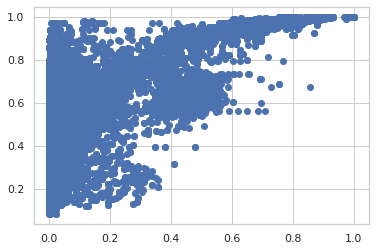

In [29]:

plt.scatter(df.dockQ,df.mm)


Text(0, 0.5, 'dockQ')

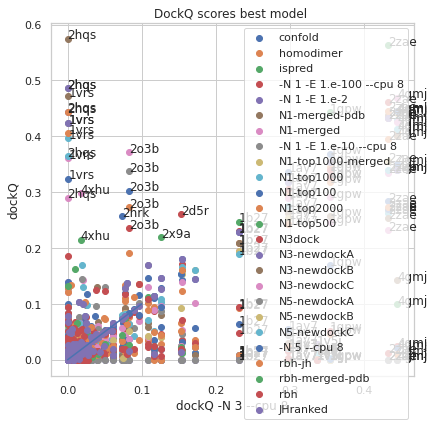

In [30]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    if d=="trRosetta":continue   
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4] # +d
        except:
            sstr=df_merged.name_y[i][0:4] #+d
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.1]
y=[0,0.1]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores best model ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'numcorrect')

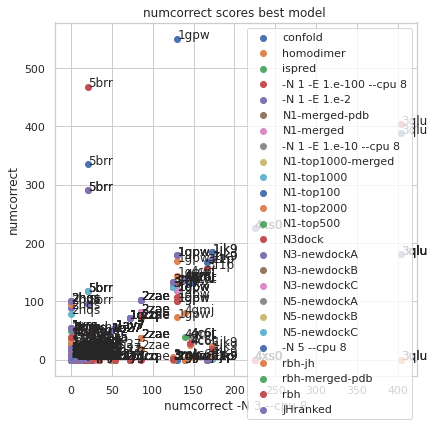

In [31]:
cutoff=5
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue 
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.numcorrect_x,df_merged.numcorrect_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.numcorrect_x[i]> cutoff or df_merged.numcorrect_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.numcorrect_x[i], df_merged.numcorrect_y[i]))
x=[0,50]
y=[0,50]
plt.plot(x,y)
ax.legend()
ax.set_title("numcorrect scores best model ")
ax.set_xlabel("numcorrect "+str(datasets[0]))
ax.set_ylabel("numcorrect")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

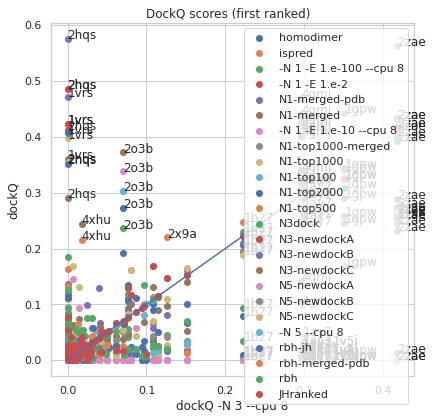

In [32]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

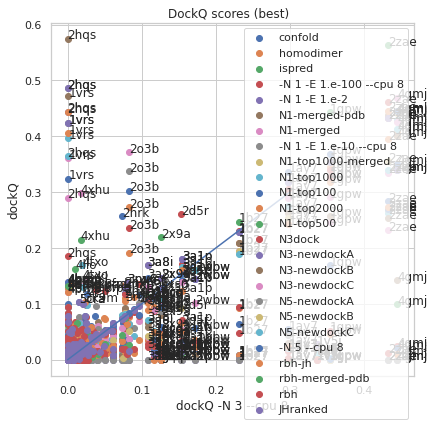

In [33]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

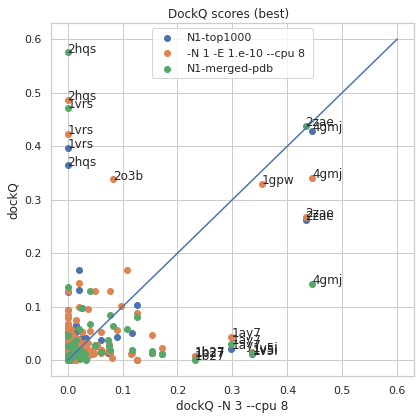

In [34]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-top1000","-N 1 -E 1.e-10 --cpu 8 ","N1-merged-pdb"]:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.6]
y=[0,0.6]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [35]:
data_max.keys()

dict_keys(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb', 'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC

Text(0, 0.5, 'dockQ trRosetta')

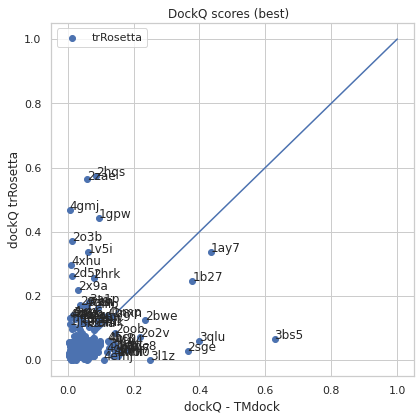

In [36]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-double"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - TMdock")
ax.set_ylabel("dockQ "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ trRosetta')

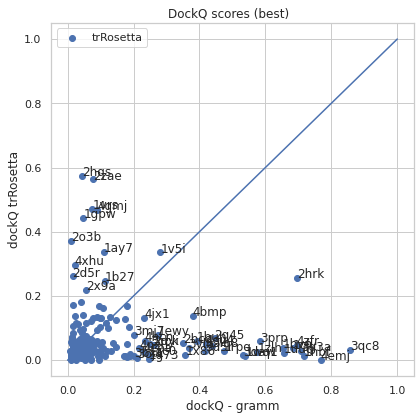

In [37]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [38]:
d="TMdock"
foo=pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
data_first[d].dockQ
foo[["dockQ_x","dockQ_y"]]
#cc=np.corrcoef(foo.dockQ_x,foo.dockQ_y)

foo.dockQ_y.isna().unique()
data_first[d].dockQ.isna().unique()

array([False])

TMdock
217 217


Text(20.200000000000003, 0.5, 'dockQ TMdock')

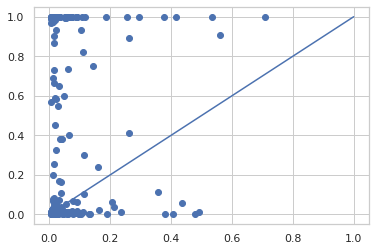

In [39]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock"]:
    #if d!="N1-merged":continue   
    print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    print(df_merged.dockQ_x.shape[0],df_merged.dockQ_y.shape[0])
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_x)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model) ") #, CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(20.200000000000003, 0.5, 'dockQ TMdock-nohomology')

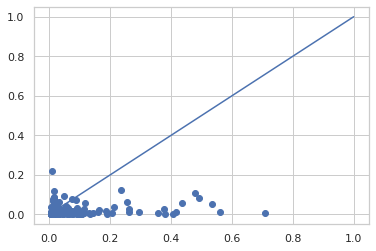

In [40]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-nohomology"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    #cc=np.corrcoef(df_merged.dockQ_y,df_merged.dockQ_y)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock-nohomology")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock')

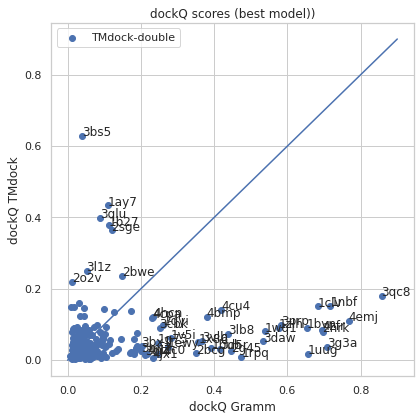

In [41]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model))" )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

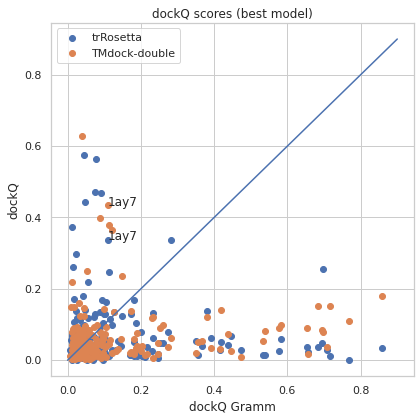

In [42]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (sstr=="3qc8" or sstr=="2hqs" or sstr=="3bs5" ):
        if (sstr=="1ay7" ):
            #if (df_merged.dockQ_y[i]> cutoff and (df_merged.dockQ_y[i]>df_merged.dockQ_x[i])):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model)") 
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [43]:
df_merged = df_max[df_max["params"].isin(["trRosetta","gramm","TMdock-double"])]
df_merged.sort_values("dockQ")

name  lenA  lenB     msa   msaA   msaB  dockQ  \
JHparams  code                                                                 
trRosetta 4emj  4emj_u2_A-4emj_u1_A   403   403  6589.0  35770  35770  0.000   
          3fap  3fap_u2_A-3fap_u1_A   108   108  1208.0  35975  35975  0.000   
          3rj3  3rj3_u2_A-3rj3_u1_A   295   295   359.0   9332   9332  0.000   
          3l1z  3l1z_u2_A-3l1z_u1_A   153   153  1390.0  48813  48813  0.000   
          1fle  1fle_u2_A-1fle_u1_A   241   241   319.0    567    567  0.001   
...                             ...   ...   ...     ...    ...    ...    ...   
gramm     2hrk  2hrk_u1_A-2hrk_u2_A   181   121     0.0     0.     0.  0.696   
          3g3a  3g3a_u1_A-3g3a_u2_A   166   130     0.0     0.     0.  0.708   
          1nbf  1nbf_u1_A-1nbf_u2_A   340    78     0.0     0.     0.  0.717   
          4emj  4emj_u1_A-4emj_u2_A   403   106     0.0     0.     0.  0.768   
          3qc8  3qc8_u1_A-3qc8_u2_A   169    82     0.0     0.     0.  0.857   

                 fnat     iRMS      LRMS  ...  CODE     params      tmAB  \
JHparams  code                            ...                              
trRosetta 4emj  0.000  687.538  1470.821  ...  4emj  trRosetta  0.886965   
          3fap  0.000  187.525   397.703  ...  3fap  trRosetta  0.839040   
          3rj3  0.000  512.189  1048.671  ...  3rj3  trRosetta  0.635370   
          3l1z  0.000  261.906   529.224  ...  3l1z  trRosetta  0.776680   
          1fle  0.000  397.029   879.077  ...  1fle  trRosetta  0.674835   
...               ...      ...       ...  ...   ...        ...       ...   
gramm     2hrk  0.978   13.721    37.969  ...  2hrk      gramm  1.000000   
          3g3a  0.787   11.568    27.296  ...  3g3a      gramm  1.000000   
          1nbf  0.649   20.191    45.946  ...  1nbf      gramm  1.000000   
          4emj  0.762    3.742    10.650  ...  4emj      gramm  1.000000   
          3qc8  0.977   11.047    18.799  ...  3qc8      gramm  1.000000   

                msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  \
JHparams  code                                                                
trRosetta 4emj    NaN   0.90839      35770   0.86941     354953         0.0   
          3fap    NaN   0.87845      35975   0.80043       1487         0.0   
          3rj3    NaN   0.80210       9332   0.48427      54903         0.0   
          3l1z    NaN   0.83424      48813   0.72778      37715         0.0   
          1fle    NaN   0.89615        567   0.45998      45351         0.0   
...               ...       ...        ...       ...        ...         ...   
gramm     2hrk    NaN   1.00000         0.   1.00000         0.         0.0   
          3g3a    NaN   1.00000         0.   1.00000         0.         0.0   
          1nbf    NaN   1.00000         0.   1.00000         0.         0.0   
          4emj    NaN   1.00000         0.   1.00000         0.         0.0   
          3qc8    NaN   1.00000         0.   1.00000         0.         0.0   

                len  
JHparams  code       
trRosetta 4emj  509  
          3fap  201  
          3rj3  421  
          3l1z  239  
          1fle  299  
...             ...  
gramm     2hrk  302  
          3g3a  296  
          1nbf  418  
          4emj  509  
          3qc8  251  

[652 rows x 40 columns]

In [44]:
len(df_merged.loc[df_merged.dockQ>0.2]["CODE"].unique())

53

In [45]:
len(df_merged.loc[(df_merged.params=="trRosetta")&(df_merged.dockQ>0.2 )]["CODE"].unique())

13

In [46]:
len(df_merged.loc[(df_merged.params=="gramm")&(df_merged.dockQ>0.2 )]["CODE"].unique())

36

In [47]:
len(df_merged.loc[(df_merged.params=="TMdock-double")&(df_merged.dockQ>0.2 )]["CODE"].unique())

8

In [48]:
len(df_merged["CODE"].unique())

218

In [49]:
df.loc[df.params=="TMdock-double"].sort_values("dockQ")

name       JHparams lenA lenB msa msaA msaB  dockQ  \
12918  1y64_u1_A-1y64_u2_A  TMdock-double  412  361   0   0.   0.      0   
13617  3hzi_u1_A-3hzi_u2_A  TMdock-double  410   70   0   0.   0.      0   
13619  3hzi_u1_A-3hzi_u2_A  TMdock-double  410   70   0   0.   0.      0   
12675  1jk9_u1_A-1jk9_u2_A  TMdock-double  218  154   0   0.   0.      0   
12673  1jk9_u1_A-1jk9_u2_A  TMdock-double  218  154   0   0.   0.      0   
...                    ...            ...  ...  ...  ..  ...  ...    ...   
13835  3qlu_u1_A-3qlu_u2_A  TMdock-double  384  374   0   0.   0.  0.398   
12428  1ay7_u1_A-1ay7_u2_A  TMdock-double   97   90   0   0.   0.  0.434   
13470  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0   0.   0.  0.539   
13466  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0   0.   0.   0.56   
13475  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0   0.   0.  0.628   

        fnat     iRMS  ...  CODE         params tmAB msaAB tmAB_max msaAB_max  \
12918      0  135.286  ...  1y64  TMdock-double  1.0   NaN      1.0        0.   
13617      0  140.378  ...  3hzi  TMdock-double  1.0   NaN      1.0        0.   
13619      0  125.318  ...  3hzi  TMdock-double  1.0   NaN      1.0        0.   
12675      0  180.465  ...  1jk9  TMdock-double  1.0   NaN      1.0        0.   
12673      0  199.118  ...  1jk9  TMdock-double  1.0   NaN      1.0        0.   
...      ...      ...  ...   ...            ...  ...   ...      ...       ...   
13835  0.542    3.667  ...  3qlu  TMdock-double  1.0   NaN      1.0        0.   
12428  0.417    2.576  ...  1ay7  TMdock-double  1.0   NaN      1.0        0.   
13470    0.9    2.876  ...  3bs5  TMdock-double  1.0   NaN      1.0        0.   
13466    0.7    2.688  ...  3bs5  TMdock-double  1.0   NaN      1.0        0.   
13475  0.833    2.384  ...  3bs5  TMdock-double  1.0   NaN      1.0        0.   

      tmAB_min msaAB_min numcorrect  len  
12918      1.0        0.          0  773  
13617      1.0        0.          0  480  
13619      1.0        0.          0  480  
12675      1.0        0.    172.806  372  
12673      1.0        0.    172.806  372  
...        ...       ...        ...  ...  
13835      1.0        0.    404.022  758  
12428      1.0        0.     53.985  187  
13470      1.0        0.     34.196  160  
13466      1.0        0.     34.196  160  
13475      1.0        0.     34.196  160  

[2160 rows x 42 columns]

In [50]:
df_merged.groupby(["CODE"]).median().sort_values("dockQ")


lenA   lenB     msa   dockQ   fnat      iRMS      LRMS  fnonnat  \
CODE                                                                     
1ycs  197.0  195.0     0.0  0.0090  0.000   64.5590  155.5760      1.0   
3rj3  295.0  126.0     0.0  0.0090  0.000   56.4120  155.5220      1.0   
2xwb  711.0  229.0     0.0  0.0100  0.000  121.5480  284.2610      1.0   
3oed  295.0  131.0     0.0  0.0110  0.000   81.3540  186.2040      1.0   
2v55  388.0  180.0     0.0  0.0110  0.000   65.6380  133.8250      1.0   
...     ...    ...     ...     ...    ...       ...       ...      ...   
1b27  109.0   90.0     0.0  0.2470  0.160   32.7470   74.6080      1.0   
2hrk  181.0  121.0     0.0  0.2570  0.326   26.7580   75.1980      1.0   
1vrs  124.0  120.5  1045.5  0.2735  0.306  119.8405  249.2075      1.0   
1v5i  276.0   78.0     0.0  0.2810  0.191   21.3190   69.6880      1.0   
1ay7   97.0   90.0     0.0  0.3370  0.417   22.9850   72.0320      1.0   

            mm      tmA  ...    auc   evalue   seqid  rank      tmAB  msaAB  \
CODE                     ...                                                  
1ycs  0.502560  1.00000  ...  0.000   134.00  66.667  10.0  0.669755    NaN   
3rj3  0.701670  1.00000  ...  0.000  9999.00   0.000  10.0  1.000000    NaN   
2xwb  0.756930  1.00000  ...  0.000   352.00  66.667  10.0  1.000000    NaN   
3oed  0.693400  1.00000  ...  0.000    74.00  66.667  10.0  1.000000    NaN   
2v55  0.683750  1.00000  ...  0.000    69.00  66.667  10.0  1.000000    NaN   
...        ...      ...  ...    ...      ...     ...   ...       ...    ...   
1b27  0.786140  1.00000  ...  0.460     4.30  50.000  10.0  1.000000    NaN   
2hrk  0.600000  1.00000  ...  0.000     0.36  19.718  10.0  1.000000    NaN   
1vrs  0.694125  0.99644  ...  0.245     3.00  38.462   6.0  0.817912    NaN   
1v5i  0.827360  1.00000  ...  0.160  9999.00   0.000  10.0  1.000000    NaN   
1ay7  0.742480  1.00000  ...  0.400  9999.00   0.000  10.0  1.000000    NaN   

      tmAB_max  tmAB_min  numcorrect    len  
CODE                                         
1ycs   1.00000  0.635710       0.000  392.0  
3rj3   1.00000  1.000000       0.000  421.0  
2xwb   1.00000  1.000000       0.000  940.0  
3oed   1.00000  1.000000       0.000  426.0  
2v55   1.00000  1.000000       0.000  568.0  
...        ...       ...         ...    ...  
1b27   1.00000  1.000000      49.025  199.0  
2hrk   1.00000  1.000000       0.000  302.0  
1vrs   0.99644  0.639385      26.994  241.0  
1v5i   1.00000  1.000000       1.000  354.0  
1ay7   1.00000  1.000000      53.985  187.0  

[218 rows x 33 columns]

Text(0, 0.5, 'dockQ TMdock')

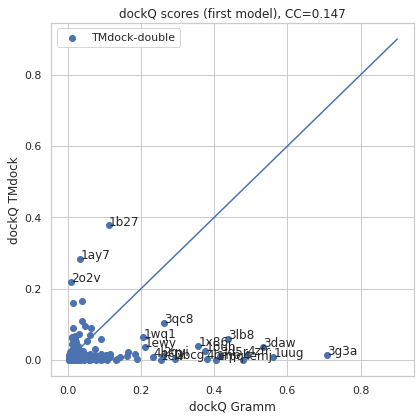

In [51]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock TMdock-double')

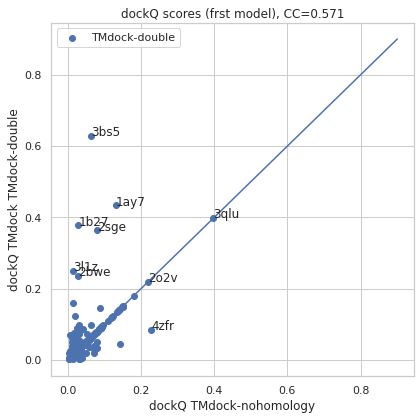

In [52]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-nohomology"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock-nohomology")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock trRosetta')

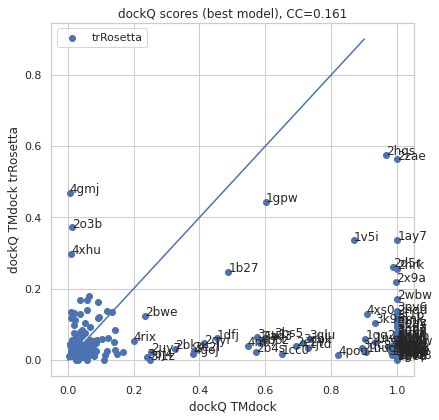

In [53]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0, 0.5, 'dockQ  PDB')

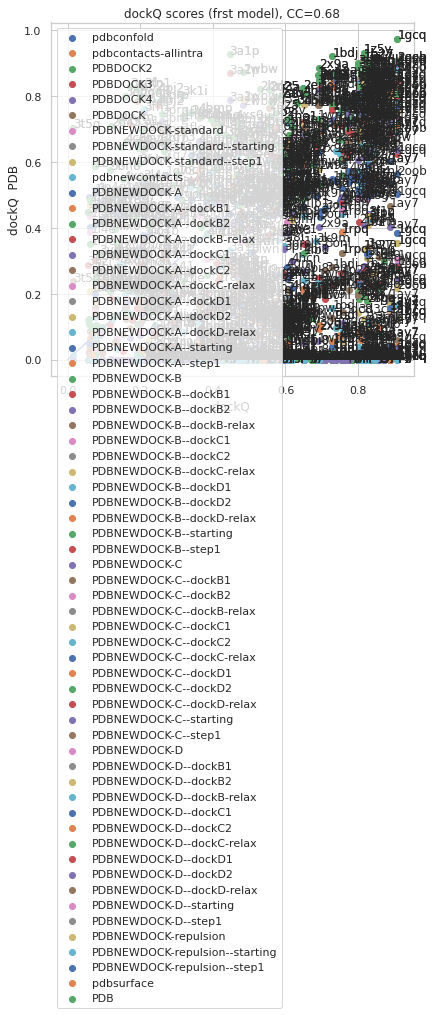

In [54]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDB|^pdb")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-repulsion--step1')

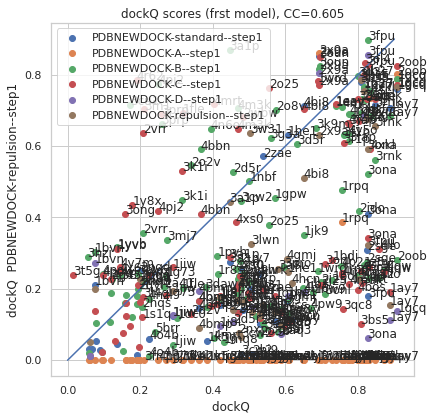

In [55]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*step1.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDB')

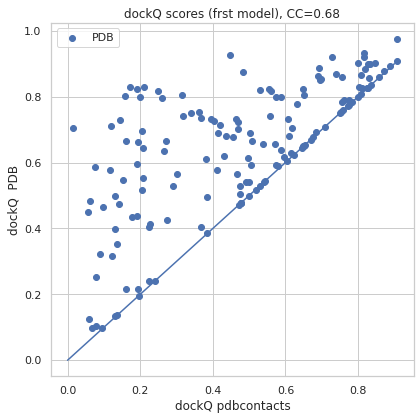

In [56]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["PDB"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ pdbcontacts")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  pdbconfold')

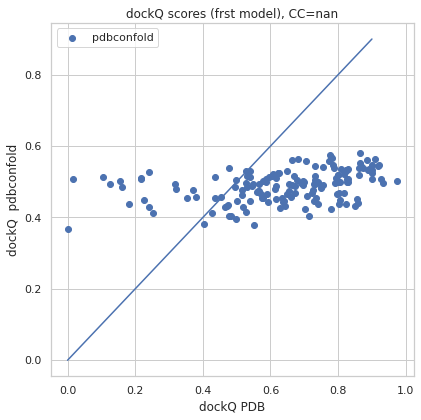

In [57]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="outer")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ PDB")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D')

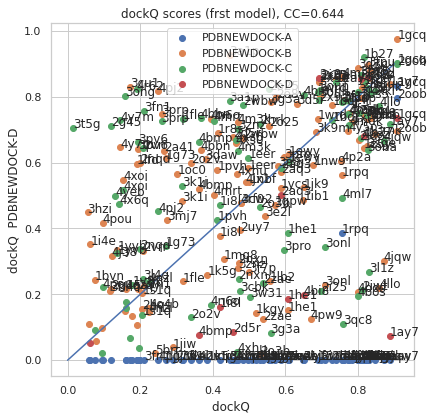

In [58]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-[ABCD]$")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockB-relax')

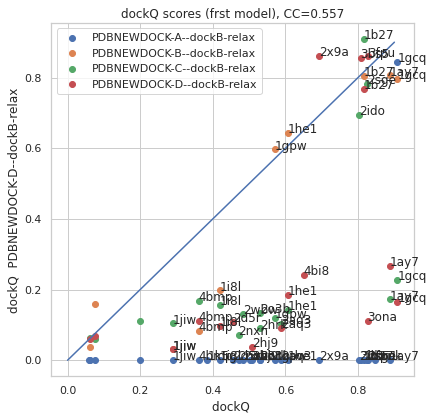

In [59]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockB-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockC-relax')

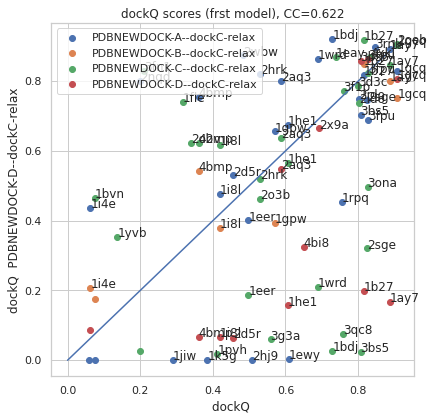

In [60]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockC-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockD-relax')

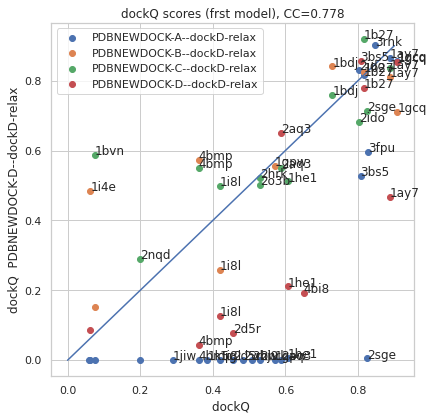

In [61]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockD-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-C')

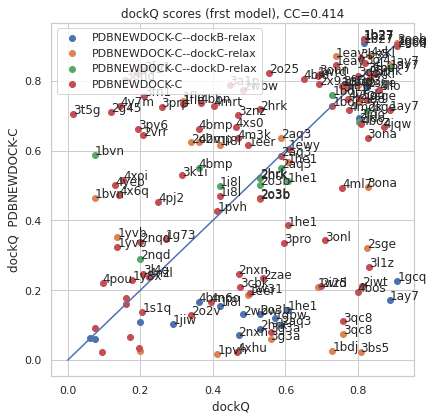

In [62]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-C--dockD-relax')

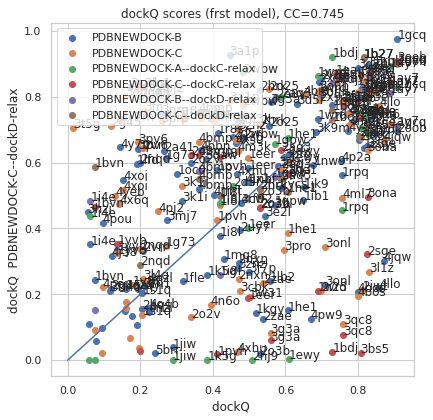

In [63]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  pdbconfold')

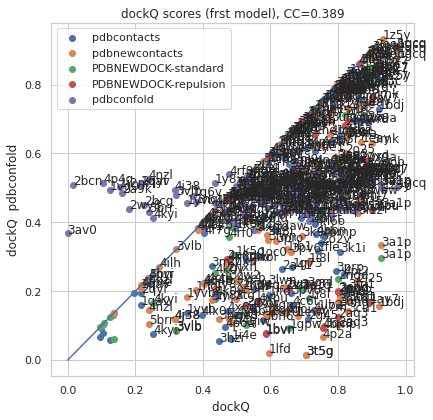

In [64]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard","PDBNEWDOCK-repulsion","pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    #if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [65]:
r=re.compile(".*relax.*")
#pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts"]
pdbset=sorted(["PDB","PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax","pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard",
               "PDBNEWDOCK-repulsion","pdbconfold"])


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A--dockC-relax")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-C")&(df_max.params.isin(pdbset) )]["CODE"].unique()

codes=smallset

In [66]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()

PDB
PDBNEWDOCK-A--dockC-relax
PDBNEWDOCK-B
PDBNEWDOCK-B--dockD-relax
PDBNEWDOCK-C
PDBNEWDOCK-C--dockC-relax
PDBNEWDOCK-C--dockD-relax
PDBNEWDOCK-repulsion
PDBNEWDOCK-standard
pdbconfold
pdbcontacts
pdbnewcontacts


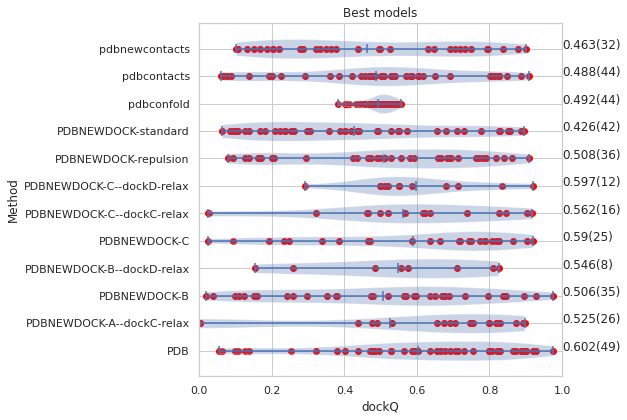

In [67]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [68]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [69]:
pdbset=[ 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA','N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8',"-N 3 --cpu 8"]
codes=df_max.loc[(df_max.params=="N3-newdockC")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes

array(['1ay7', '1b27', '1bvn', '1gcq', '1gpw', '1he1', '1i4e', '1i8l',
       '2aq3', '2b4s', '2d5r', '2hj9', '2hrk', '2ido', '2nqd', '2nxn',
       '2o3b', '2sge', '2wbw', '2x9a', '2zae', '3a1p', '3a8i', '3bs5',
       '3cw2', '3fpu', '3lwn', '3ona', '3rnk', '3w31', '4bi8', '4bmp',
       '4gmj', '4hcn', '4xhu'], dtype=object)

Text(0, 0.5, 'dockQ  -N 3 --cpu 8')

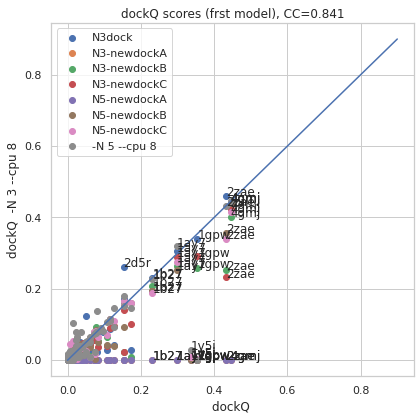

In [70]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="-N 3 --cpu 8":continue
    df_merged = pd.merge(data_max["-N 3 --cpu 8"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

-N 3 --cpu 8 35
-N 5 --cpu 8 35
N3-newdockA 34
N3-newdockB 30
N3-newdockC 35
N3dock 34
N5-newdockA 33
N5-newdockB 32
N5-newdockC 33


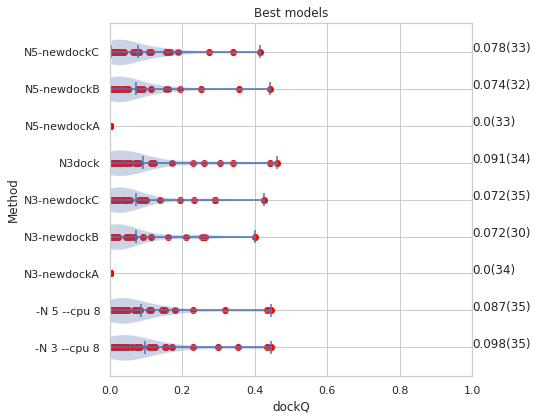

In [71]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    print (d,len(data[i]))
    i+=1
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [72]:
pdbset=sorted(["N1","N3"])

In [73]:
for d in pdbset:
    print (d,len(df_max.loc[(df_max.params==d)]["CODE"].unique()))

N1 0
N3 0


In [74]:
all_df

JHparams  code                 name  lenA  lenB     msa   msaA  \
0    -N 3 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97  1060.0   2034   
1    -N 3 --cpu 8  1b27  1b27_u2_A-1b27_u1_A   109   109   733.0   2034   
2    -N 3 --cpu 8  1bvn  1bvn_u2_A-1bvn_u1_A   496   496    95.0  52623   
3    -N 3 --cpu 8  1gcq  1gcq_u2_A-1gcq_u1_A    66    66  1365.0  77704   
4    -N 3 --cpu 8  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7137.0  67629   
..            ...   ...                  ...   ...   ...     ...    ...   
296   N5-newdockC  4bi8  4bi8_u1_A-4bi8_u2_A   164    94    51.0    291   
297   N5-newdockC  4bmp  4bmp_u1_A-4bmp_u2_A   301   118  4607.0   9429   
298   N5-newdockC  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   6344   
299   N5-newdockC  4hcn  4hcn_u1_A-4hcn_u2_A   250    77     1.0     20   
300   N5-newdockC  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   9970   

      msaB  dockQ   fnat  ...  CODE        params      tmAB  msaAB  tmAB_max  \
0     2034  0.298  0.278  ...  1ay7  -N 3 --cpu 8  0.828190    NaN   0.84625   
1     2034  0.231  0.160  ...  1b27  -N 3 --cpu 8  0.824750    NaN   0.85428   
2    52623  0.014  0.000  ...  1bvn  -N 3 --cpu 8  0.619740    NaN   0.70905   
3    77704  0.117  0.240  ...  1gcq  -N 3 --cpu 8  0.555390    NaN   0.63426   
4    67629  0.354  0.320  ...  1gpw  -N 3 --cpu 8  0.888935    NaN   0.89468   
..     ...    ...    ...  ...   ...           ...       ...    ...       ...   
296    382  0.026  0.000  ...  4bi8   N5-newdockC  0.695005    NaN   0.78100   
297  15729  0.004  0.000  ...  4bmp   N5-newdockC  0.811060    NaN   0.86858   
298   6344  0.414  0.634  ...  4gmj   N5-newdockC  0.831935    NaN   0.85148   
299  41925  0.014  0.000  ...  4hcn   N5-newdockC  0.467315    NaN   0.61756   
300   9970  0.007  0.000  ...  4xhu   N5-newdockC  0.730560    NaN   0.75557   

     msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
0         2034   0.81013       1485      53.985  187  
1         2034   0.79522       1484      49.025  199  
2        52623   0.53043        123       0.000  571  
3        77704   0.52080      77497      71.760  123  
4        67629   0.88319      58466     130.000  456  
..         ...       ...        ...         ...  ...  
296        382   0.60901        291       0.000  258  
297       9429   0.75354      15729       0.000  419  
298       6344   0.82721       1653     139.104  489  
299      41925   0.31707         20       0.000  327  
300       9970   0.70555        548       0.000  447  

[301 rows x 42 columns]

In [75]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()


In [76]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [77]:
r=re.compile(".*relax.*")
pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts","pdbconfold","PDB"]


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A")&(df_max.params.isin(pdbset) )]["CODE"].unique()


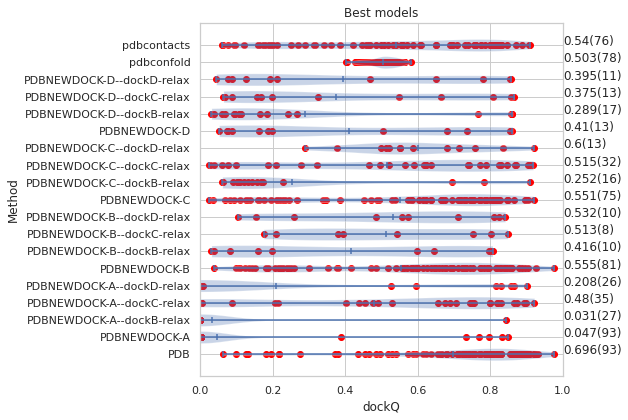

In [78]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [79]:
codes

array(['1ay7', '1b27', '1bdj', '1buh', '1bvn', '1cc0', '1eay', '1eer',
       '1ewy', '1fle', '1fq1', '1g6v', '1g73', '1gcq', '1gpw', '1he1',
       '1i4e', '1i8l', '1jiw', '1k5g', '1kgy', '1lb2', '1lfd', '1nql',
       '1qav', '1rpq', '1vg0', '1vrs', '1wrd', '1xt9', '1y8x', '1z5y',
       '2aq3', '2b4s', '2bwe', '2c2v', '2d5r', '2ejf', '2g45', '2grx',
       '2gwf', '2hj9', '2hrk', '2i25', '2ido', '2iwt', '2nqd', '2o25',
       '2o2v', '2oob', '2qyi', '2sge', '2wbw', '2wy7', '2wy8', '2x9a',
       '2xgy', '2zae', '3a1p', '3bs5', '3cu1', '3d3c', '3f1p', '3fap',
       '3fn1', '3fpu', '3g3a', '3k1i', '3l1z', '3oj4', '3ona', '3onl',
       '3qc8', '3rj3', '3rnk', '4bi8', '4bmp', '4bos', '4boz', '4c6t',
       '4jqw', '4m3k', '4ml7', '4pj2', '4pou', '4r62', '4txo', '4xkl',
       '4xs0', '4y5o', '4zfr', '5cra', '5eg3'], dtype=object)

In [80]:
all_df

JHparams  code                           name  lenA  lenB     msa  \
0            PDB  1ay7  1ay7_u2_A-1ay7_u1_A.pdb-step1    97    97  1060.0   
1            PDB  1b27  1b27_u2_A-1b27_u1_A.pdb-step1   109   109   733.0   
2            PDB  1bdj  1bdj_u2_A-1bdj_u1_A.pdb-step1   129   129  5651.0   
3            PDB  1buh  1buh_u2_A-1buh_u1_A.pdb-step1   291   291  1177.0   
4            PDB  1bvn  1bvn_u1_A-1bvn_u2_A.pdb-step1   496    75    95.0   
..           ...   ...                            ...   ...   ...     ...   
722  pdbcontacts  4r62            4r62_u2_A-4r62_u1_A    77   154  1399.0   
723  pdbcontacts  4xkl            4xkl_u2_A-4xkl_u1_A    34    76   227.0   
724  pdbcontacts  4xs0            4xs0_u2_A-4xs0_u1_A   141   147  3324.0   
725  pdbcontacts  4y5o            4y5o_u2_A-4y5o_u1_A    85    94   357.0   
726  pdbcontacts  5eg3            5eg3_u1_A-5eg3_u2_A   303   105   421.0   

    msaA msaB  dockQ   fnat  ...  CODE       params      tmAB  msaAB  \
0     0.   0.  0.892  0.861  ...  1ay7          PDB  0.998225    NaN   
1     0.   0.  0.919  0.800  ...  1b27          PDB  0.998015    NaN   
2     0.   0.  0.921  0.882  ...  1bdj          PDB  0.991980    NaN   
3     0.   0.  0.818  0.711  ...  1buh          PDB  0.954555    NaN   
4     0.   0.  0.587  0.846  ...  1bvn          PDB  0.894115    NaN   
..   ...  ...    ...    ...  ...   ...          ...       ...    ...   
722   0.   0.  0.191  0.458  ...  4r62  pdbcontacts  0.592005    NaN   
723   0.   0.  0.833  0.639  ...  4xkl  pdbcontacts  0.982790    NaN   
724   0.   0.  0.463  0.796  ...  4xs0  pdbcontacts  0.832175    NaN   
725   0.   0.  0.773  0.658  ...  4y5o  pdbcontacts  0.951865    NaN   
726   0.   0.  0.094  0.000  ...  5eg3  pdbcontacts  0.909250    NaN   

     tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
0     0.99846         0.   0.99799         0.         0.0  187  
1     0.99893         0.   0.99710         0.         0.0  199  
2     0.99475         0.   0.99097         0.         0.0  247  
3     0.98447         0.   0.92464         0.         0.0  363  
4     0.90969         0.   0.88836         0.         0.0  571  
..        ...        ...       ...        ...         ...  ...  
722   0.84316         0.   0.34085         0.         0.0  231  
723   0.99132         0.   0.97426         0.         0.0  110  
724   0.97030         0.   0.69405         0.         0.0  288  
725   0.99590         0.   0.90783         0.         0.0  179  
726   0.91808         0.   0.90042         0.         0.0  408  

[727 rows x 42 columns]

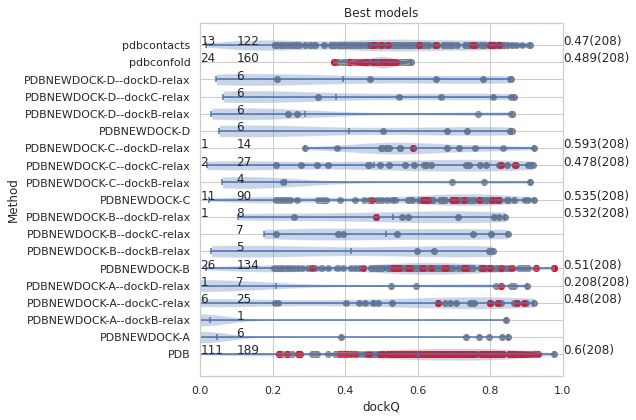

In [81]:
# FInd best method for each model.
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3))+"("+str(length[good_df.JHparams[i]])+")"
                    ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


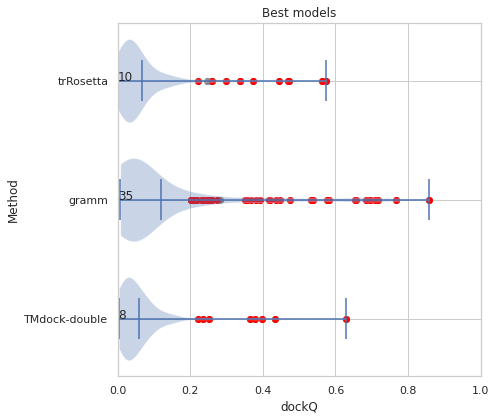

In [82]:
compareset=["trRosetta","gramm","TMdock-double"]
codes=df_max.loc[df_max.params.isin(compareset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(compareset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(compareset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(compareset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        #ax.annotate(str(round(average[best_df.JHparams[i]],3))+
        #            "("+str(length[good_df.JHparams[i]])+")"
        #            ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


In [83]:
best_df

index       JHparams  code                 name  lenA  lenB     msa  \
0    1173          gramm  3qc8  3qc8_u1_A-3qc8_u2_A   169    82     0.0   
1    1178          gramm  4emj  4emj_u1_A-4emj_u2_A   403   106     0.0   
2    1153          gramm  1nbf  1nbf_u1_A-1nbf_u2_A   340    78     0.0   
3    1168          gramm  3g3a  3g3a_u1_A-3g3a_u2_A   166   130     0.0   
4    1162          gramm  2hrk  2hrk_u1_A-2hrk_u2_A   181   121     0.0   
5    1182          gramm  4zfr  4zfr_u1_A-4zfr_u2_A   186    77     0.0   
6    1150          gramm  1clv  1clv_u1_A-1clv_u2_A   471    33     0.0   
7    1155          gramm  1uug  1uug_u1_A-1uug_u2_A   230    83     0.0   
8    1148          gramm  1bvn  1bvn_u1_A-1bvn_u2_A   496    75     0.0   
9    1131  TMdock-double  3bs5  3bs5_u1_A-3bs5_u2_A    84    76     0.0   
10   1172          gramm  3prp  3prp_u1_A-3prp_u2_A   184    77     0.0   
11   1159          gramm  1zlh  1zlh_u1_A-1zlh_u2_A   306    76     0.0   
12   1610      trRosetta  2hqs  2hqs_u2_A-2hqs_u1_A   398   398  2535.0   
13   1614      trRosetta  2zae  2zae_u2_A-2zae_u1_A   107   107  1125.0   
14   1157          gramm  1wq1  1wq1_u1_A-1wq1_u2_A   325   167     0.0   
15   1167          gramm  3daw  3daw_u1_A-3daw_u2_A   360   143     0.0   
16   1154          gramm  1rpq  1rpq_u1_A-1rpq_u2_A   174    22     0.0   
17   1608      trRosetta  1vrs  1vrs_u2_A-1vrs_u1_A   124   124  2091.0   
18   1615      trRosetta  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   
19   1161          gramm  2g45  2g45_u1_A-2g45_u2_A   114    77     0.0   
20   1606      trRosetta  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7203.0   
21   1169          gramm  3lb8  3lb8_u1_A-3lb8_u2_A   422   107     0.0   
22   1126  TMdock-double  1ay7  1ay7_u1_A-1ay7_u2_A    97    90     0.0   
23   1177          gramm  4cu4  4cu4_u1_A-4cu4_u2_A   706    22     0.0   
24   1166          gramm  3d5r  3d5r_u1_A-3d5r_u2_A   295    62     0.0   
25   1133  TMdock-double  3qlu  3qlu_u1_A-3qlu_u2_A   384   374     0.0   
26   1147          gramm  1buh  1buh_u1_A-1buh_u2_A   291    72     0.0   
27   1175          gramm  4bmp  4bmp_u1_A-4bmp_u2_A   301   118     0.0   
28   1127  TMdock-double  1b27  1b27_u1_A-1b27_u2_A   109    90     0.0   
29   1612      trRosetta  2o3b  2o3b_u2_A-2o3b_u1_A   240   240   456.0   
30   1174          gramm  3vlb  3vlb_u1_A-3vlb_u2_A   413   222     0.0   
31   1130  TMdock-double  2sge  2sge_u1_A-2sge_u2_A   186    57     0.0   
32   1158          gramm  1x86  1x86_u1_A-1x86_u2_A   353   181     0.0   
33   1160          gramm  2bcg  2bcg_u1_A-2bcg_u2_A   440   179     0.0   
34   1607      trRosetta  1v5i  1v5i_u2_A-1v5i_u1_A   276   276  1922.0   
35   1616      trRosetta  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   
36   1151          gramm  1ewy  1ewy_u1_A-1ewy_u2_A   304    99     0.0   
37   1163          gramm  2qyi  2qyi_u1_A-2qyi_u2_A   224   180     0.0   
38   1609      trRosetta  2d5r  2d5r_u2_A-2d5r_u1_A   265   265   521.0   
39   1132  TMdock-double  3l1z  3l1z_u1_A-3l1z_u2_A   153    86     0.0   
40   1165          gramm  3cbk  3cbk_u1_A-3cbk_u2_A   257   111     0.0   
41   1149          gramm  1cc0  1cc0_u1_A-1cc0_u2_A   178   149     0.0   
42   1152          gramm  1g73  1g73_u1_A-1g73_u2_A   174    97     0.0   
43   1128  TMdock-double  2bwe  2bwe_u1_A-2bwe_u2_A    78    47     0.0   
44   1179          gramm  4hcn  4hcn_u1_A-4hcn_u2_A   250    77     0.0   
45   1180          gramm  4jx1  4jx1_u1_A-4jx1_u2_A   405   107     0.0   
46   1176          gramm  4cpa  4cpa_u1_A-4cpa_u2_A   308    40     0.0   
47   1613      trRosetta  2x9a  2x9a_u2_A-2x9a_u1_A   103   103     4.0   
48   1129  TMdock-double  2o2v  2o2v_u1_A-2o2v_u2_A   114    94     0.0   
49   1181          gramm  4nzl  4nzl_u1_A-4nzl_u2_A   219   100     0.0   
50   1171          gramm  3oj4  3oj4_u1_A-3oj4_u2_A   151    77     0.0   
51   1164          gramm  3bx1  3bx1_u1_A-3bx1_u2_A   270   182     0.0   
52   1170          gramm  3mj

In [84]:
codes

array(['1ay7', '1b27', '1bdj', '1buh', '1bvn', '1cc0', '1clv', '1dfj',
       '1eay', '1eer', '1ewy', '1fle', '1fq1', '1g6v', '1g73', '1gcq',
       '1gg2', '1gpw', '1he1', '1i2m', '1i4e', '1i8l', '1ib1', '1jiw',
       '1jk9', '1jtd', '1k5g', '1kgy', '1lb2', '1lfd', '1mq8', '1nbf',
       '1nql', '1nw9', '1oc0', '1pvh', '1qav', '1r8s', '1rpq', '1s1q',
       '1te1', '1tmq', '1uug', '1v5i', '1vg0', '1wq1', '1wrd', '1x86',
       '1xt9', '1y64', '1y8x', '1ycs', '1yu6', '1yvb', '1z5y', '1zlh',
       '2a41', '2a5d', '2a9k', '2abz', '2aq3', '2b4s', '2bcg', '2bcn',
       '2bku', '2bwe', '2c0l', '2c2v', '2ch4', '2d5r', '2ejf', '2g45',
       '2grx', '2gwf', '2hj9', '2hqs', '2hrk', '2i25', '2ido', '2iwt',
       '2nqd', '2nxn', '2o25', '2o2v', '2o3b', '2o8v', '2oob', '2qyi',
       '2sge', '2uy7', '2v55', '2vdb', '2vrr', '2wbw', '2wy7', '2wy8',
       '2x9a', '2xgy', '2xwb', '2zae', '3a1p', '3a8i', '3av0', '3bh6',
       '3bs5', '3buz', '3bx1', '3cbk', '3cu1', '3cw2', '3d3c', '3d5r',
      

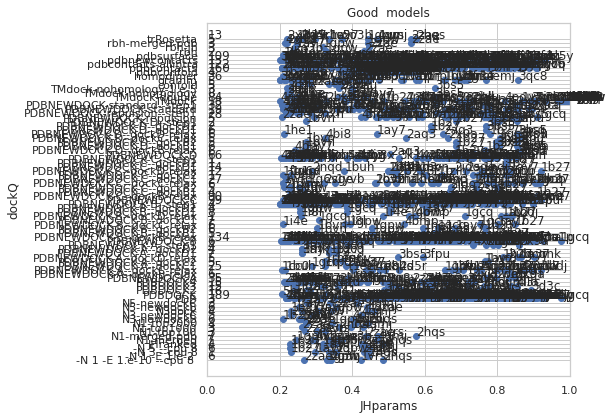

In [85]:

f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
ax.set_title("Good  models")
ax.set_xlabel("JHparams")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

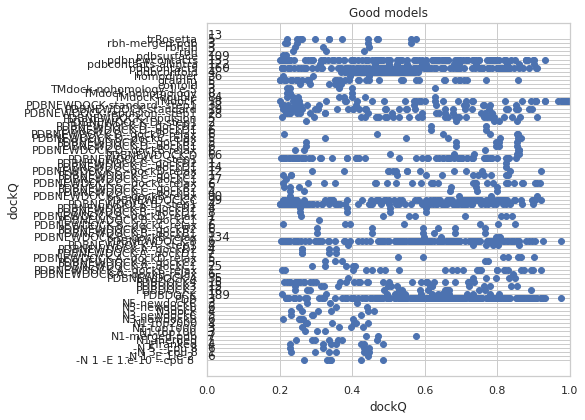

In [86]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [87]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA',
       'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold',
       'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3',
       'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard',
       'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1',
       'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1',
       'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax',
       'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2',
       'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1',
       'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax',
       'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B',
       'PDBNEWDOCK-B--dockB

In [88]:
# here we find what method is best for each target

r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print(excludecolumns)
excludecolumns+=["confold","rbh-merged-pdb"]
tempdf=newdf.loc[~newdf.JHparams.isin(excludecolumns)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

['gramm', 'pdbconfold', 'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC2', 'PDBNEWDOCK-B--dockC-relax', 'PDBNEWDOCK-B--dockD1', 'PDBNEWDOCK-B--dockD2', 'PDBNEWDOCK-B--dockD-relax', 'PDBNEWDOCK-B--starting', 'PDBNEWDOCK-B--step1', 'PDBNEWDOCK-C', 'PDBNEWDOCK-C--dockB1', 'PDBNEWDOCK-C--dockB2', 'PDBNEWDOCK-C--dockB-relax', 'PDBNEWDOCK-C--dockC1', 'PDBNEWDOCK-C--dockC2', 'PDBNEWDOCK-C--dockC-relax', 'PDBNEWDOCK-C--dockD1', 

index       JHparams  code                 name  lenA  lenB     msa  \
6      10   -N 3 --cpu 8  1v5i  1v5i_u2_A-1v5i_u1_A   276   276  1922.0   
10      8   -N 3 --cpu 8  1b27  1b27_u2_A-1b27_u1_A   109   109   733.0   
7      13   -N 5 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97  1060.0   
5      19       JHranked  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7137.0   
2      29      N1-merged  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   
4      27      N1-merged  2o3b  2o3b_u2_A-2o3b_u1_A   240   240   456.0   
8      30      N1-merged  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   
0      32  N1-merged-pdb  2hqs  2hqs_u2_A-2hqs_u1_A   398   398  2368.0   
1      31  N1-merged-pdb  1vrs  1vrs_u2_A-1vrs_u1_A   124   124   836.0   
3      60         N3dock  2zae  2zae_u2_A-2zae_u1_A   107   107  1125.0   
9      59         N3dock  2d5r  2d5r_u2_A-2d5r_u1_A   265   265   521.0   

     msaA   msaB  dockQ  ...  CODE         params      tmAB  msaAB  tmAB_max  \
6   54177  54177  0.336  ...  1v5i   -N 3 --cpu 8  0.826270    NaN   0.89294   
10   2034   2034  0.231  ...  1b27   -N 3 --cpu 8  0.824750    NaN   0.85428   
7    2034   2034  0.319  ...  1ay7   -N 5 --cpu 8  0.830380    NaN   0.84095   
5   67629   7554  0.354  ...  1gpw       JHranked  0.888935    NaN   0.89468   
2      0.     0.  0.469  ...  4gmj      N1-merged  0.803190    NaN   0.82588   
4      0.     0.  0.372  ...  2o3b      N1-merged  0.727490    NaN   0.83406   
8      0.     0.  0.298  ...  4xhu      N1-merged  0.829155    NaN   0.84232   
0      0.     0.  0.575  ...  2hqs  N1-merged-pdb  0.969605    NaN   0.97016   
1      0.     0.  0.472  ...  1vrs  N1-merged-pdb  0.989810    NaN   0.99288   
3    1659   1659  0.461  ...  2zae         N3dock  0.792020    NaN   0.79343   
9    6154   6154  0.261  ...  2d5r         N3dock  0.774685    NaN   0.87927   

    msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
6       54177   0.75960      12066       1.000  354  
10       2034   0.79522       1484      49.025  199  
7        2034   0.81981       1485      53.985  187  
5        7554   0.88623      58466     179.000  456  
2          0.   0.78050         0.     137.151  489  
4          0.   0.62495         0.      29.008  384  
8          0.   0.81599         0.      19.910  447  
0          0.   0.96905         0.     100.035  507  
1          0.   0.98674         0.      53.988  241  
3        1659   0.79061       1521     103.041  200  
9        6154   0.68937       1771      17.996  386  

[11 rows x 43 columns]

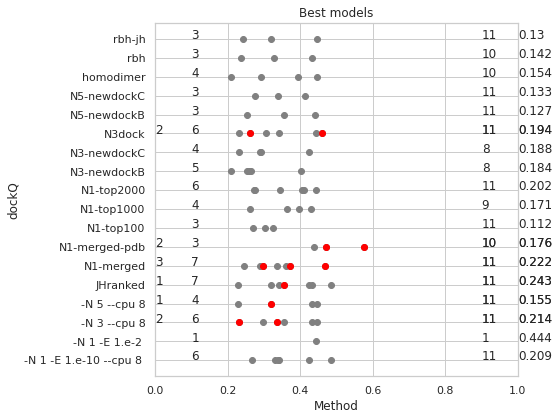

In [89]:
# FInd best method for each model.
codes=best_df["code"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
good_df=newdf.loc[(newdf.code.isin(codes))&(~newdf.JHparams.isin(excludecolumns))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_xlabel("Method")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
for d in datasets:
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3)),(1.0, best_df.JHparams[i]))
        ax.annotate(str(length[best_df.JHparams[i]]),(.9, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        ax.annotate(str(length[good_df.JHparams[i]]),(.9, good_df.JHparams[i]))


In [90]:
df.sort_values('dockQ', ascending=False).drop_duplicates(["code"])

name       JHparams lenA lenB  msa msaA msaB  dockQ  \
17077  1nbf_u1_A-1nbf_u2_A         TMdock  340   78    0   0.   0.      1   
17998  3kld_u1_A-3kld_u2_A         TMdock  384  265    0   0.   0.      1   
17977  3k1i_u1_A-3k1i_u2_A         TMdock  116  102    0   0.   0.      1   
17957  3g3a_u1_A-3g3a_u2_A         TMdock  166  130    0   0.   0.      1   
17487  2grx_u1_A-2grx_u2_A         TMdock  708   91    0   0.   0.      1   
...                    ...            ...  ...  ...  ...  ...  ...    ...   
14208  4lsx_u1_A-4lsx_u2_A  TMdock-double  744  187    0   0.   0.   0.07   
23329  4yoc_u1_A-4yoc_u2_A            PDB  905  530  333   0.   0.  0.054   
14308  4ol0_u1_A-4ol0_u2_A  TMdock-double  890  206    0   0.   0.  0.041   
2841   4rws_u1_A-4rws_u2_A          gramm  434   72    0   0.   0.  0.021   
2878   4v2c_u1_A-4v2c_u2_A          gramm  324  107    0   0.   0.  0.019   

        fnat    iRMS  ...  CODE         params     tmAB msaAB tmAB_max  \
17077      1       0  ...  1nbf         TMdock  1.00000   NaN  1.00000   
17998      1       0  ...  3kld         TMdock  1.00000   NaN  1.00000   
17977      1       0  ...  3k1i         TMdock  1.00000   NaN  1.00000   
17957      1       0  ...  3g3a         TMdock  1.00000   NaN  1.00000   
17487      1   0.009  ...  2grx         TMdock  1.00000   NaN  1.00000   
...      ...     ...  ...   ...            ...      ...   ...      ...   
14208  0.156   19.07  ...  4lsx  TMdock-double  1.00000   NaN  1.00000   
23329  0.159  65.047  ...  4yoc            PDB  0.25367   NaN  0.32173   
14308      0  12.041  ...  4ol0  TMdock-double  1.00000   NaN  1.00000   
2841       0  13.383  ...  4rws          gramm  1.00000   NaN  1.00000   
2878       0  14.698  ...  4v2c          gramm  1.00000   NaN  1.00000   

      msaAB_max tmAB_min msaAB_min numcorrect   len  
17077        0.  1.00000        0.          0   418  
17998        0.  1.00000        0.          0   649  
17977        0.  1.00000        0.      6.996   218  
17957        0.  1.00000        0.          0   296  
17487        0.  1.00000        0.          0   799  
...         ...      ...       ...        ...   ...  
14208        0.  1.00000        0.      13.91   931  
23329        0.  0.18561        0.          0  1435  
14308        0.  1.00000        0.          0  1096  
2841         0.  1.00000        0.          0   506  
2878         0.  1.00000        0.          0   431  

[218 rows x 42 columns]

In [91]:
df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].groupby("name").max()


JHparams  lenA  lenB     msa   msaA   msaB  dockQ  \
name                                                                         
1ay7_u1_A-1ay7_u2_A        rbh-jh    97    90  1060.0   1485   2034  0.319   
1ay7_u2_A-1ay7_u1_A     homodimer    90    97  1060.0   2034   1485  0.260   
1b27_u1_A-1b27_u2_A     homodimer   109    90   733.0   1484   2034  0.230   
1b27_u2_A-1b27_u1_A     homodimer    90   109   733.0   2034   1484  0.231   
1gpw_u1_A-1gpw_u2_A        rbh-jh   252   204  7137.0  58466   7554  0.351   
1gpw_u2_A-1gpw_u1_A        rbh-jh   204   252  7137.0   7554  58466  0.354   
1v5i_u1_A-1v5i_u2_A  -N 3 --cpu 8   276    78  1922.0  54177  12066  0.336   
1vrs_u1_A-1vrs_u2_A    N1-top2000   124   117   836.0   1396   1245  0.472   
1vrs_u2_A-1vrs_u1_A    N1-top2000   117   124  2091.0   1245   1396  0.324   
2d5r_u2_A-2d5r_u1_A        N3dock   121   265   521.0   1771   6154  0.261   
2hqs_u1_A-2hqs_u2_A    N1-top2000   398   109  2396.0   9156   4788  0.575   
2hqs_u2_A-2hqs_u1_A    N1-top2000   109   398  2396.0   4788   9156  0.480   
2o3b_u1_A-2o3b_u2_A           rbh   240   144   100.0   1898     86  0.372   
2zae_u1_A-2zae_u2_A        rbh-jh   107    93  1125.0    183     78  0.433   
2zae_u2_A-2zae_u1_A        rbh-jh    93   107  1125.0     78    183  0.461   
4gmj_u1_A-4gmj_u2_A     homodimer   253   236  1189.0   6344   1653  0.469   
4gmj_u2_A-4gmj_u1_A     homodimer   236   253  1189.0   1653   6344  0.445   
4xhu_u1_A-4xhu_u2_A     N1-merged   352    95   211.0     0.     0.  0.244   
4xhu_u2_A-4xhu_u1_A     N1-merged    95   352   410.0     0.     0.  0.298   

                      fnat    iRMS    LRMS  ...  CODE        params      tmAB  \
name                                        ...                                 
1ay7_u1_A-1ay7_u2_A  0.306   4.002   9.104  ...  1ay7        rbh-jh  0.830380   
1ay7_u2_A-1ay7_u1_A  0.306   4.433  11.977  ...  1ay7     homodimer  0.817620   
1b27_u1_A-1b27_u2_A  0.160   4.793  10.176  ...  1b27     homodimer  0.825820   
1b27_u2_A-1b27_u1_A  0.160   5.319   9.542  ...  1b27     homodimer  0.810645   
1gpw_u1_A-1gpw_u2_A  0.320   4.776  11.778  ...  1gpw        rbh-jh  0.889680   
1gpw_u2_A-1gpw_u1_A  0.333   5.865   9.606  ...  1gpw        rbh-jh  0.894335   
1v5i_u1_A-1v5i_u2_A  0.191   3.748   5.851  ...  1v5i  -N 3 --cpu 8  0.818890   
1vrs_u1_A-1vrs_u2_A  0.449   2.953   9.785  ...  1vrs    N1-top2000  0.989810   
1vrs_u2_A-1vrs_u1_A  0.306   7.831  11.866  ...  1vrs    N1-top2000  0.897465   
2d5r_u2_A-2d5r_u1_A  0.203  10.074   7.537  ...  2d5r        N3dock  0.752890   
2hqs_u1_A-2hqs_u2_A  0.526   3.771  10.318  ...  2hqs    N1-top2000  0.969605   
2hqs_u2_A-2hqs_u1_A  0.395   2.806   7.435  ...  2hqs    N1-top2000  0.907610   
2o3b_u1_A-2o3b_u2_A  0.556   4.959   9.920  ...  2o3b           rbh  0.727490   
2zae_u1_A-2zae_u2_A  0.371   6.495   8.823  ...  2zae        rbh-jh  0.992575   
2zae_u2_A-2zae_u1_A  0.484   6.490   9.655  ...  2zae        rbh-jh  0.983450   
4gmj_u1_A-4gmj_u2_A  0.780   3.975  36.835  ...  4gmj     homodimer  0.836225   
4gmj_u2_A-4gmj_u1_A  0.780   4.389  14.976  ...  4gmj     homodimer  0.831935   
4xhu_u1_A-4xhu_u2_A  0.185   5.002   9.149  ...  4xhu     N1-merged  0.809280   
4xhu_u2_A-4xhu_u1_A  0.481   4.861  12.250  ...  4xhu     N1-merged  0.829155   

                     msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
name                                                                   
1ay7_u1_A-1ay7_u2_A    NaN   0.84625       2034   0.81981       1485   
1ay7_u2_A-1ay7_u1_A    NaN   0.84181       2034   0.79459       1485   
1b27_u1_A-1b27_u2_A    NaN   0.85658       2034   0.79542       1484   
1b27_u2_A-1b27_u1_A    NaN   0.83444       2034   0.78801       1484   
1gpw_u1_A-1gpw_u2_A    NaN   0.89229       7554   0.88822      58466   
1gpw_u2_A-1gpw_u1_A    NaN   0.89745       7554   0.89220      58466   
1v5i_u1_A-1v5i_u2_A    NaN   0.88557      54177   0.75221      12066   
1vrs_u1_A-1vrs_u2_A    NaN   0.99288

['gramm', 'pdbconfold', 'pdbcontacts-allintra', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC2', 'PDBNEWDOCK-B--dockC-relax', 'PDBNEWDOCK-B--dockD1', 'PDBNEWDOCK-B--dockD2', 'PDBNEWDOCK-B--dockD-relax', 'PDBNEWDOCK-B--starting', 'PDBNEWDOCK-B--step1', 'PDBNEWDOCK-C', 'PDBNEWDOCK-C--dockB1', 'PDBNEWDOCK-C--dockB2', 'PDBNEWDOCK-C--dockB-relax', 'PDBNEWDOCK-C--dockC1', 'PDBNEWDOCK-C--dockC2', 'PDBNEWDOCK-C--dockC-relax', 'PDBNEWDOCK-C--dockD1', 

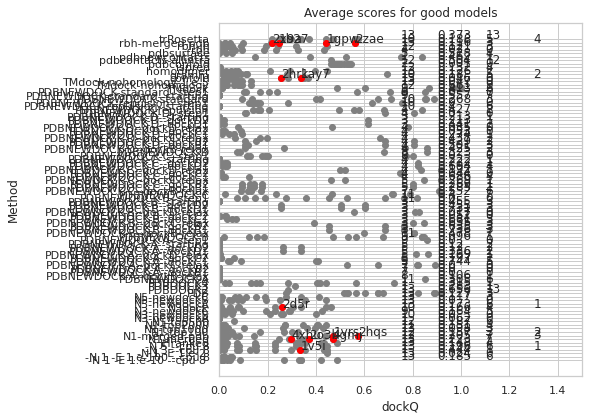

In [92]:
r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print (excludecolumns)
includeTR=["pdbcontacts","PDBDOCK","TMdock-double"]
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best methods")

new_df=df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].sort_values('dockQ', ascending=False).drop_duplicates(["code"]).reset_index()
codes=new_df.CODE.unique()
#print(new_df)
#newdf.sort_values(["JHparams","dockQ","code"],inplace=True)

tempdf=df_max.loc[(df_max.CODE.isin(codes)) & (~df_max.params.isin(includeTR))].reset_index()
plt.scatter(tempdf.dockQ,tempdf.params,color="grey")
#print(tempdf[tempdf.params=="N1-top1000"])
plt.scatter(new_df.dockQ,new_df.params,color="red")
#print(new_df[new_df.params=="N1-top1000"])

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Average scores for good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("Method")
ax.set(xlim=[0,1])
done={}
average={}
length={}
ax.set(xlim=[0,1.5])
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
    average[d]=df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"])
for i, txt in enumerate(tempdf.name):
    #print (i,txt, newdf.JHparams[i])
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(tempdf.loc[(tempdf.params==tempdf.params[i])&(tempdf.dockQ>cutoff)])
    
    #print (numhit,newdf.JHparams[i])
    if done[tempdf.params[i]]==0:
        done[tempdf.params[i]]=1
        ax.annotate(str(numhit),(1.1, tempdf.params[i]))
        #ax.annotate("0",(.1, tempdf.JHparams[i]))  
        ax.annotate(str(round(average[tempdf.params[i]],3)),(.9, tempdf.params[i]))          
        ax.annotate(str(round(length[tempdf.params[i]],3)),(.75, tempdf.params[i]))  
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
for i, txt in enumerate(new_df.name):
    #print (i,txt,newdf.dockQ[i], newdf.JHparams[i])
    sstr=txt[0:4]
    ax.annotate(sstr, (new_df.dockQ[i], new_df.params[i]))
    numhit=len(new_df.loc[new_df.params==new_df.params[i]])
    #numhit2=len(tempdf.loc[tempdf.JHparams==tempdf.params[i]])
    #print (numhit,newdf.JHparams[i])
    if done[new_df.params[i]]==0:
        done[new_df.params[i]]=1
        ax.annotate(str(numhit),(1.3, new_df.params[i]))  
        #ax.annotate(str(numhit2),(-0.1, new_df.JHparams[i]))


In [93]:
cutoff=0.1

In [94]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']

cutoff=0.1

In [95]:
goodmodels=df_max.loc[(df_max.dockQ>cutoff)&(df_max.params.isin(JHsets)) ]["CODE"].unique()

/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


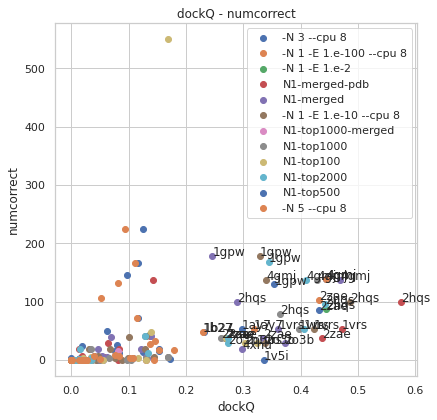

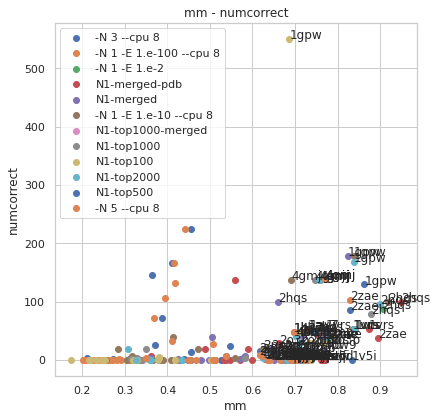

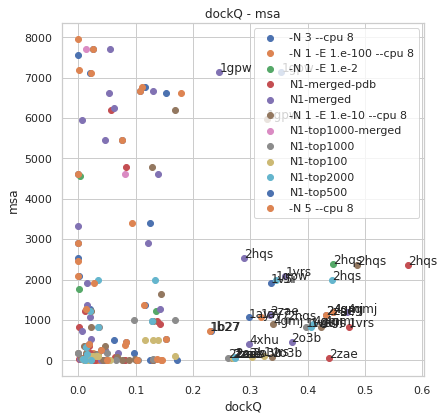

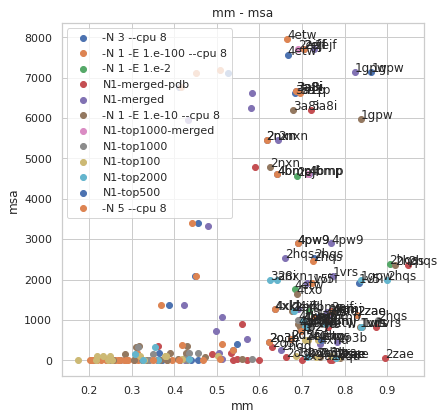

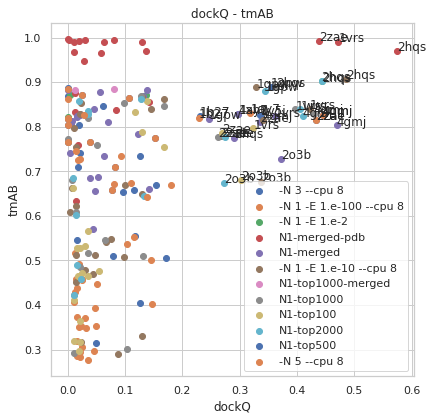

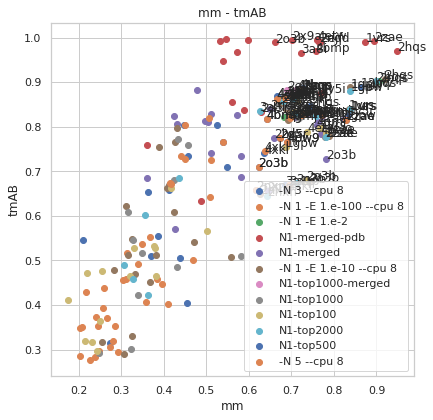

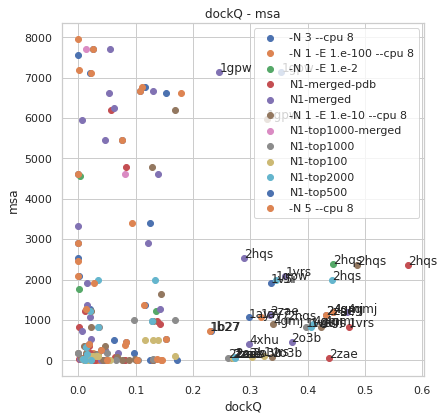

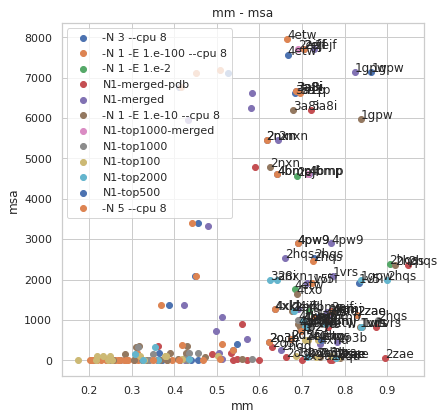

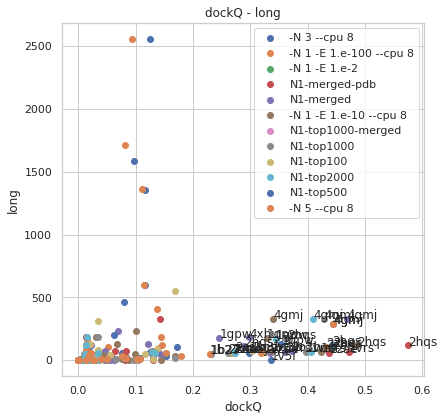

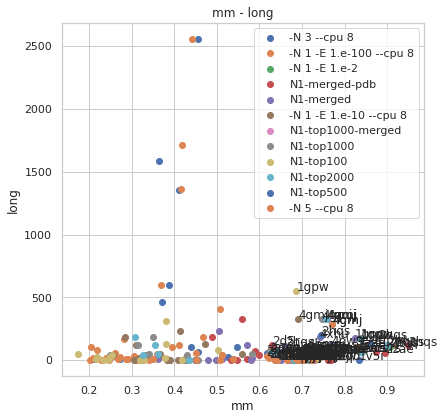

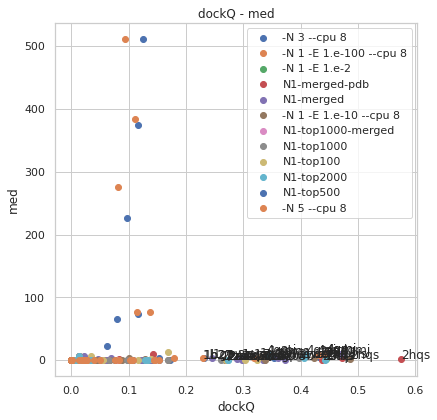

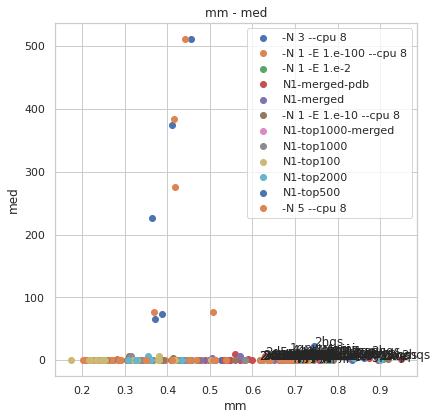

In [96]:
tempdf=df_max.loc[df_max.params.isin(JHsets)] 


tempdf=tempdf.loc[tempdf.CODE.isin(goodmodels)]
cf={"dockQ":0.2,"mm":0.6,"numcorrect":50}
for y in ["numcorrect","msa","tmAB","msa","long","med"]:
    for x in ["dockQ","mm","numcorrect"]:
        cutoff=cf[x]
        #print (Name)
         #if (Name != "lenA"):
        #    continue
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        for d in JHsets:
            xdata=tempdf.loc[tempdf.params==d][x]
            ydata=tempdf.loc[tempdf.params==d][y]
            plt.scatter(xdata,ydata,label=d)
            cc=np.corrcoef(xdata,ydata)
            for i, txt in enumerate(tempdf.loc[tempdf.params==d].name):
                sstr=txt[0:4]
                if (xdata[i]>cutoff):
                    ax.annotate(sstr, (xdata[i], ydata[i]))
        ax.set_title(x + " - " + y )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.legend()
    plt.close()

In [97]:
goodmodels

array(['1gpw', '1vrs', '2hqs', '2nxn', '2o3b', '2zae', '3a8i', '3fpu',
       '4bmp', '4c6t', '4gmj', '4txo', '1ay7', '1b27', '1gcq', '1v5i',
       '2d5r', '2wbw', '2x9a', '3a1p', '3f1p', '4xs0', '3pv6', '5cra',
       '4pw9', '4xhu', '4xkl', '2nqd', '2ejf', '4etw'], dtype=object)

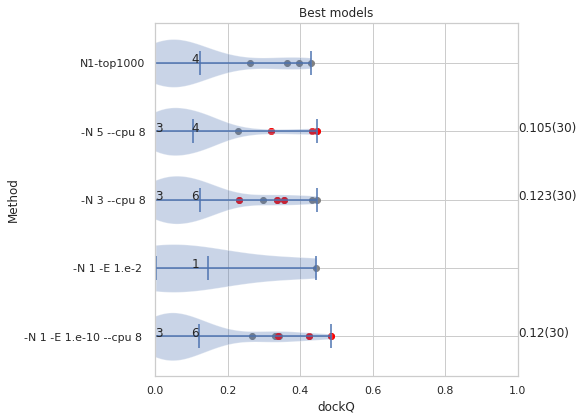

In [98]:
pdbset=['-N 3 --cpu 8',
 '-N 1 -E 1.e-2 ',
 '-N 1 -E 1.e-10 --cpu 8 ',
 'N1-top1000',
 '-N 5 --cpu 8']
codes=goodmodels
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3))+"("+str(length[good_df.JHparams[i]])+")"
                    ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ')

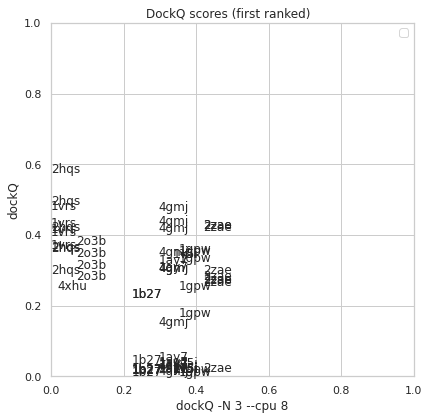

In [99]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in JHsets:
  
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
#x=[0,0.3]
#y=[0,0.3]
#plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [100]:
goodmodels

array(['1gpw', '1vrs', '2hqs', '2nxn', '2o3b', '2zae', '3a8i', '3fpu',
       '4bmp', '4c6t', '4gmj', '4txo', '1ay7', '1b27', '1gcq', '1v5i',
       '2d5r', '2wbw', '2x9a', '3a1p', '3f1p', '4xs0', '3pv6', '5cra',
       '4pw9', '4xhu', '4xkl', '2nqd', '2ejf', '4etw'], dtype=object)

In [101]:
JHsets

['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ',
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [102]:
JHsets1=['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ']

In [103]:
JHsets2=[
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [104]:
JHsets=['-N 3 --cpu 8',
 '-N 1 -E 1.e-2 --cpu 8',
 '-N 1 -E 1.e-10 --cpu 8 ',
 '-N 5 --cpu 8']
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()


In [105]:
train_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
test_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()

In [106]:
good_df=df_first.loc[(df_first.code.isin(goodmodels)&(df_first.JHparams.isin(JHsets)))].reset_index()

In [108]:
good_df=df_first.loc[(df_first.JHparams.isin(JHsets))].reset_index()

In [109]:
good_df

index                 name      JHparams lenA lenB   msa    msaA    msaB  \
0        0  1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1        2  1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
2        4  1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
3        6  1buh_u1_A-1buh_u2_A  -N 3 --cpu 8  291   72  1177  555226    1820   
4        8  1bvn_u1_A-1bvn_u2_A  -N 3 --cpu 8  496   75    95   52623     123   
..     ...                  ...           ...  ...  ...   ...     ...     ...   
648   5597  4zfr_u1_A-4zfr_u2_A  -N 5 --cpu 8  186   77  1358   14421   42037   
649   5599  5brr_u1_A-5brr_u2_A  -N 5 --cpu 8  378  266   611   13523   45636   
650   5601  5cec_u1_A-5cec_u2_A  -N 5 --cpu 8  403  191  1594   33067  312612   
651   5603  5cra_u1_A-5cra_u2_A  -N 5 --cpu 8  193   77     1      11   42026   
652   5605  5eg3_u1_A-5eg3_u2_A  -N 5 --cpu 8  303  105   499  560629   26558   

     dockQ   fnat  ...  CODE        params      tmAB msaAB tmAB_max msaAB_max  \
0    0.298  0.222  ...  1ay7  -N 3 --cpu 8  0.828190   NaN  0.84625      2034   
1    0.223   0.12  ...  1b27  -N 3 --cpu 8  0.824750   NaN  0.85428      2034   
2        0      0  ...  1bdj  -N 3 --cpu 8  0.861435   NaN  0.92240    349880   
3        0      0  ...  1buh  -N 3 --cpu 8  0.560760   NaN  0.73259    555226   
4    0.006      0  ...  1bvn  -N 3 --cpu 8  0.619740   NaN  0.70905     52623   
..     ...    ...  ...   ...           ...       ...   ...      ...       ...   
648      0      0  ...  4zfr  -N 5 --cpu 8  0.796765   NaN  0.83034     42037   
649   0.02      0  ...  5brr  -N 5 --cpu 8  0.790865   NaN  0.80934     45636   
650      0      0  ...  5cec  -N 5 --cpu 8  0.628690   NaN  0.85640     33067   
651  0.008      0  ...  5cra  -N 5 --cpu 8  0.536735   NaN  0.71605     42026   
652      0      0  ...  5eg3  -N 5 --cpu 8  0.733390   NaN  0.77821    560629   

    tmAB_min msaAB_min numcorrect  len  
0    0.81013      1485     53.985  187  
1    0.79522      1484     49.025  199  
2    0.80047     23051          0  247  
3    0.38893      1820          0  363  
4    0.53043       123          0  571  
..       ...       ...        ...  ...  
648  0.76319     14421          0  263  
649  0.77239     13523          2  644  
650  0.40098    312612          0  594  
651  0.35742        11          0  270  
652  0.68857     26558          0  408  

[653 rows x 43 columns]

In [110]:
cutoff

0.2

AttributeError: 'float' object has no attribute 'shape'

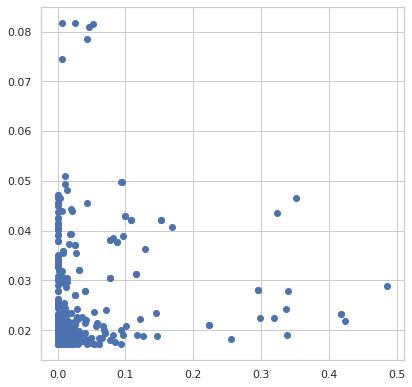

In [111]:
ydata=good_df.dockQ
cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]

#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]


reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [ ]:
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

In [112]:

for s in JHsets:
    set_df=good_df.loc[good_df.params==s]
    ypred=set_df["dockQ"].to_list()
    (i,j,dockq,mm)=get_ranks(set_df,ypred)
    print (s,i,j,dockq,mm)

-N 3 --cpu 8 6 6 0.0 0.0
-N 1 -E 1.e-2 --cpu 8 0 0 0 0
-N 1 -E 1.e-10 --cpu 8  6 6 0.0 0.0
-N 5 --cpu 8 4 4 0.0 0.0


In [113]:
xdata=other_df[cols]
ydata=other_df.dockQ

ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred,)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


NameError: name 'other_df' is not defined

In [ ]:
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()
good_df

In [114]:
# Now we try all combinations - no plots
set1_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
set2_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()

cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
ydata=good_df.dockQ

res={}
maxvalue=0
for c in cols:
    xdata=good_df[[c]]
    reg.fit(xdata,ydata)
    ypred = reg.predict(xdata)
    print (c,round(np.corrcoef(ydata,ypred)[0,1],3))
    res[c]=np.corrcoef(ydata,ypred)[0,1]
    maxvalue=max(res[c],maxvalue)    
for c in cols:
    for d in cols:
        xdata=good_df[[c,d]]
        reg.fit(xdata,ydata)
        ypred = reg.predict(xdata)
        #print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        res[c+d]=np.corrcoef(ydata,ypred)[0,1]
        #if (res[c+d]-maxvalue>0.0):
        #    print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        (i,j,k,l)=get_ranks(good_df,ypred)
        print (c,d,i,j,k,l)

AttributeError: 'float' object has no attribute 'shape'

In [115]:

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)


Intercept: 
 0.1275539729912042
Coefficients: 
 [-0.00013415]


Text(0, 0.5, 'predicted dockQ')

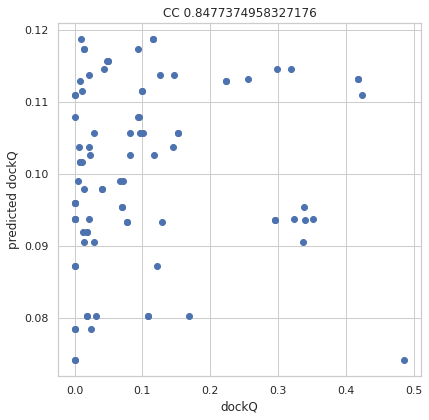

In [117]:
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
#cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
